Autoregressive hidden Markov models (AR-HMMs)

https://ericmjl.github.io/essays-on-data-science/machine-learning/markov-models/

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import sys
import time

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm

In [4]:
import theano.tensor as tt
import theano.tensor.slinalg as sla  # theano-wrapped scipy linear algebra
import theano.tensor.nlinalg as nla  # theano-wrapped numpy linear algebra
import theano

In [5]:
from scipy.stats import multinomial
from scipy.stats import norm
from scipy.stats import poisson

from typing import List

In [6]:
import matplotlib.pyplot as plt

In [7]:
import arviz as az


In [8]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [9]:
theano.config.exception_verbosity = 'high'
os.environ["MKL_THREADING_LAYER"]="GNU"

In [10]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on theano: v{}'.format(theano.version.version))
print('Running on PYMC3: v{}'.format(pm.__version__))

Running on numpy: v1.18.1
Running on theano: v1.0.4
Running on PYMC3: v3.8


In [11]:
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

## Initializing a Markov chain


In [12]:
p_init = np.array([0.2, 0.8])


In [173]:
p_transition = np.array([[0.90, 0.1],
                         [0.2, 0.80]])

In [14]:
p_transition

array([[0.9, 0.1],
       [0.2, 0.8]])

In [ ]:
assert p_transition[0, :].sum() == 1
assert p_transition[1, :].sum() == 1

## Equilibrium or Stationary Distribution


In [15]:
p_next = p_init @ p_transition
p_next

array([0.34, 0.66])

In [16]:
p_next = p_next @ p_transition
p_next

array([0.438, 0.562])

In [17]:
p_state_t = [p_init]

for i in range(200):  # 200 time steps sorta, kinda, approximates infinite time :)
    p_state_t.append(p_state_t[-1] @ p_transition)

In [18]:
state_distributions = pd.DataFrame(p_state_t)
state_distributions

0         1
0    0.200000  0.800000
1    0.340000  0.660000
2    0.438000  0.562000
3    0.506600  0.493400
4    0.554620  0.445380
..        ...       ...
196  0.666667  0.333333
197  0.666667  0.333333
198  0.666667  0.333333
199  0.666667  0.333333
200  0.666667  0.333333

[201 rows x 2 columns]

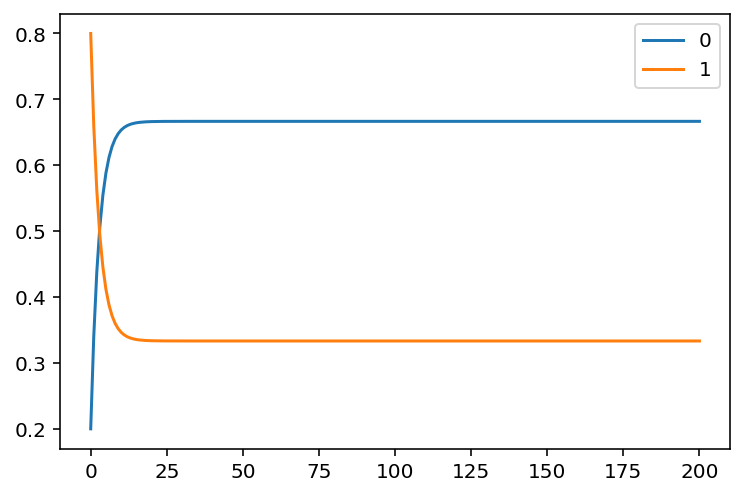

In [19]:
state_distributions.plot();

In [20]:
print(p_state_t[-1])


[0.66666667 0.33333333]


In [21]:
def equilibrium_distribution(p_transition):
    n_states = p_transition.shape[0]
    A = np.append(
        arr=p_transition.T - np.eye(n_states),
        values=np.ones(n_states).reshape(1, -1),
        axis=0
    )
    b = np.transpose(np.array([0] * n_states + [1]))
    p_eq = np.linalg.solve(
        a=np.transpose(A).dot(A),
        b=np.transpose(A).dot(b)
    )
    return p_eq

In [23]:
print(equilibrium_distribution(p_transition))

[0.66666667 0.33333333]


In [24]:
# alternative
def equilibrium_distribution(p_transition):
    """This implementation comes from Colin Carroll, who kindly reviewed the notebook"""
    n_states = p_transition.shape[0]
    A = np.append(
        arr=p_transition.T - np.eye(n_states),
        values=np.ones(n_states).reshape(1, -1),
        axis=0
    )
    # Moore-Penrose pseudoinverse = (A^TA)^{-1}A^T
    pinv = np.linalg.pinv(A)
    # Return last row
    return pinv.T[-1]

In [26]:
print(equilibrium_distribution(p_transition))

[0.66666667 0.33333333]


## Generating a Markov Sequence


In [27]:
def markov_sequence(p_init: np.array, p_transition: np.array, sequence_length: int) -> List[int]:
    """
    Generate a Markov sequence based on p_init and p_transition.
    """
    if p_init is None:
        p_init = equilibrium_distribution(p_transition)
    initial_state = list(multinomial.rvs(1, p_init)).index(1)

    states = [initial_state]
    for _ in range(sequence_length - 1):
        p_tr = p_transition[states[-1]]
        new_state = list(multinomial.rvs(1, p_tr)).index(1)
        states.append(new_state)
    return states

In [28]:
p_init

array([0.2, 0.8])

In [29]:
p_transition

array([[0.9, 0.1],
       [0.2, 0.8]])

In [30]:
states = markov_sequence(p_init, p_transition, sequence_length=1000)

In [31]:
len(states)

1000

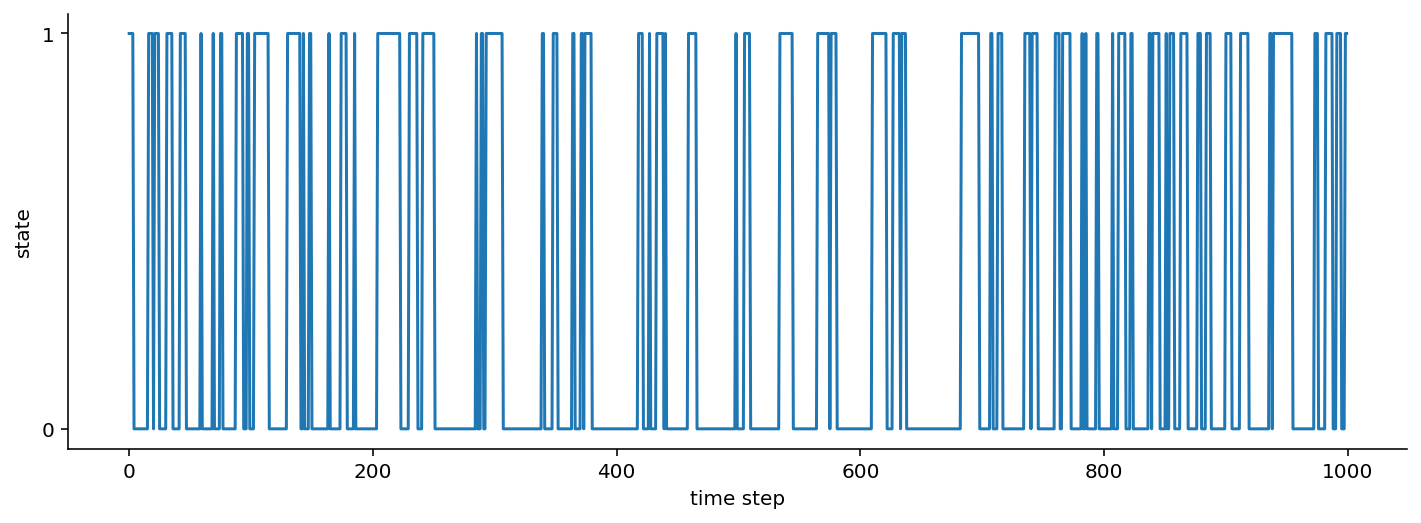

In [33]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(states)
plt.xlabel("time step")
plt.ylabel("state")
plt.yticks([0, 1])
sns.despine()

## Gaussian Emissions

In [34]:
def gaussian_emissions(states: List[int], mus: List[float], sigmas: List[float]) -> List[float]:
    emissions = []
    for state in states:
        loc = mus[state]
        scale = sigmas[state]
        e = norm.rvs(loc=loc, scale=scale)
        emissions.append(e)
    return emissions

In [35]:
def poisson_emissions(states: List[int], lam: List[float]) -> List[int]:
    emissions = []
    for state in states:
        rate = lam[state]
        e = poisson.rvs(rate)
        emissions.append(e)
    return emissions

In [36]:
def plot_emissions(states, emissions):
    fig, axes = plt.subplots(figsize=(16, 8), nrows=2, ncols=1, sharex=True)

    axes[0].plot(states)
    axes[0].set_title("States")
    axes[1].plot(emissions)
    axes[1].set_title("Emissions")
    sns.despine();

In [37]:
len(states)

1000

In [86]:
gaussian_ems = gaussian_emissions(states, mus=[-10, 10], sigmas=[0.1, 0.5])

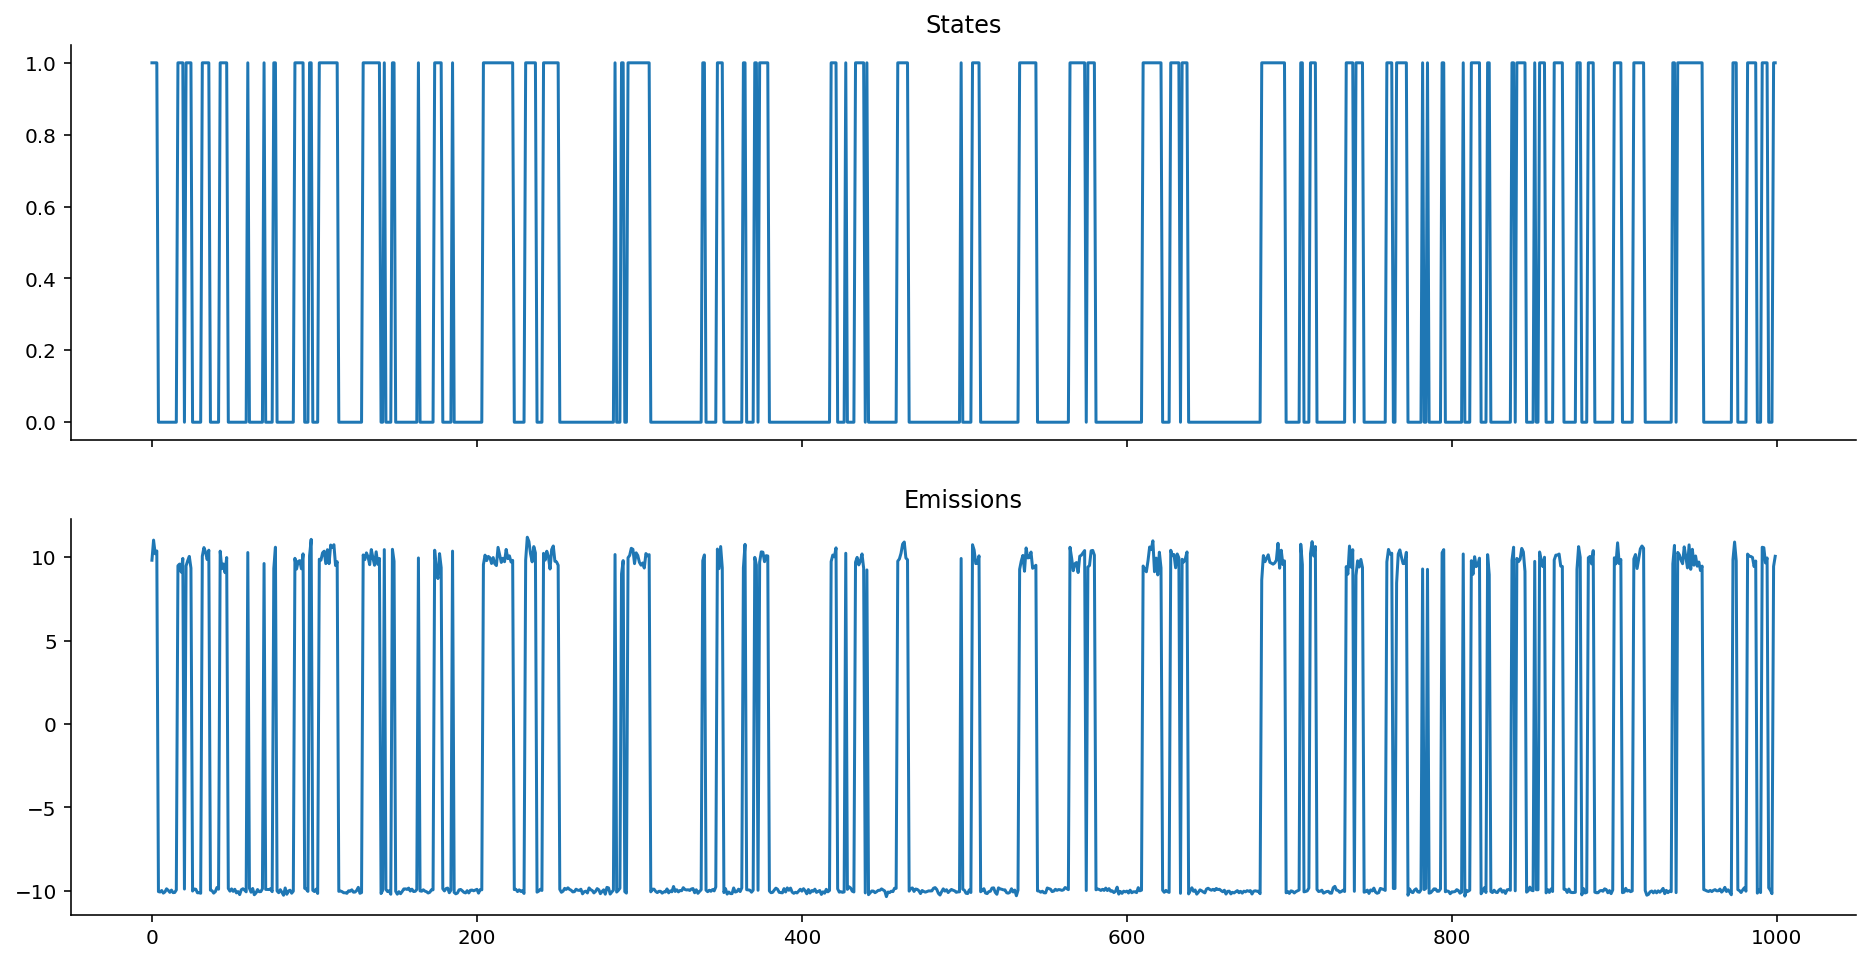

In [87]:
plot_emissions(states, gaussian_ems)

In [88]:
poisson_ems = poisson_emissions(states, lam=[1, 50])


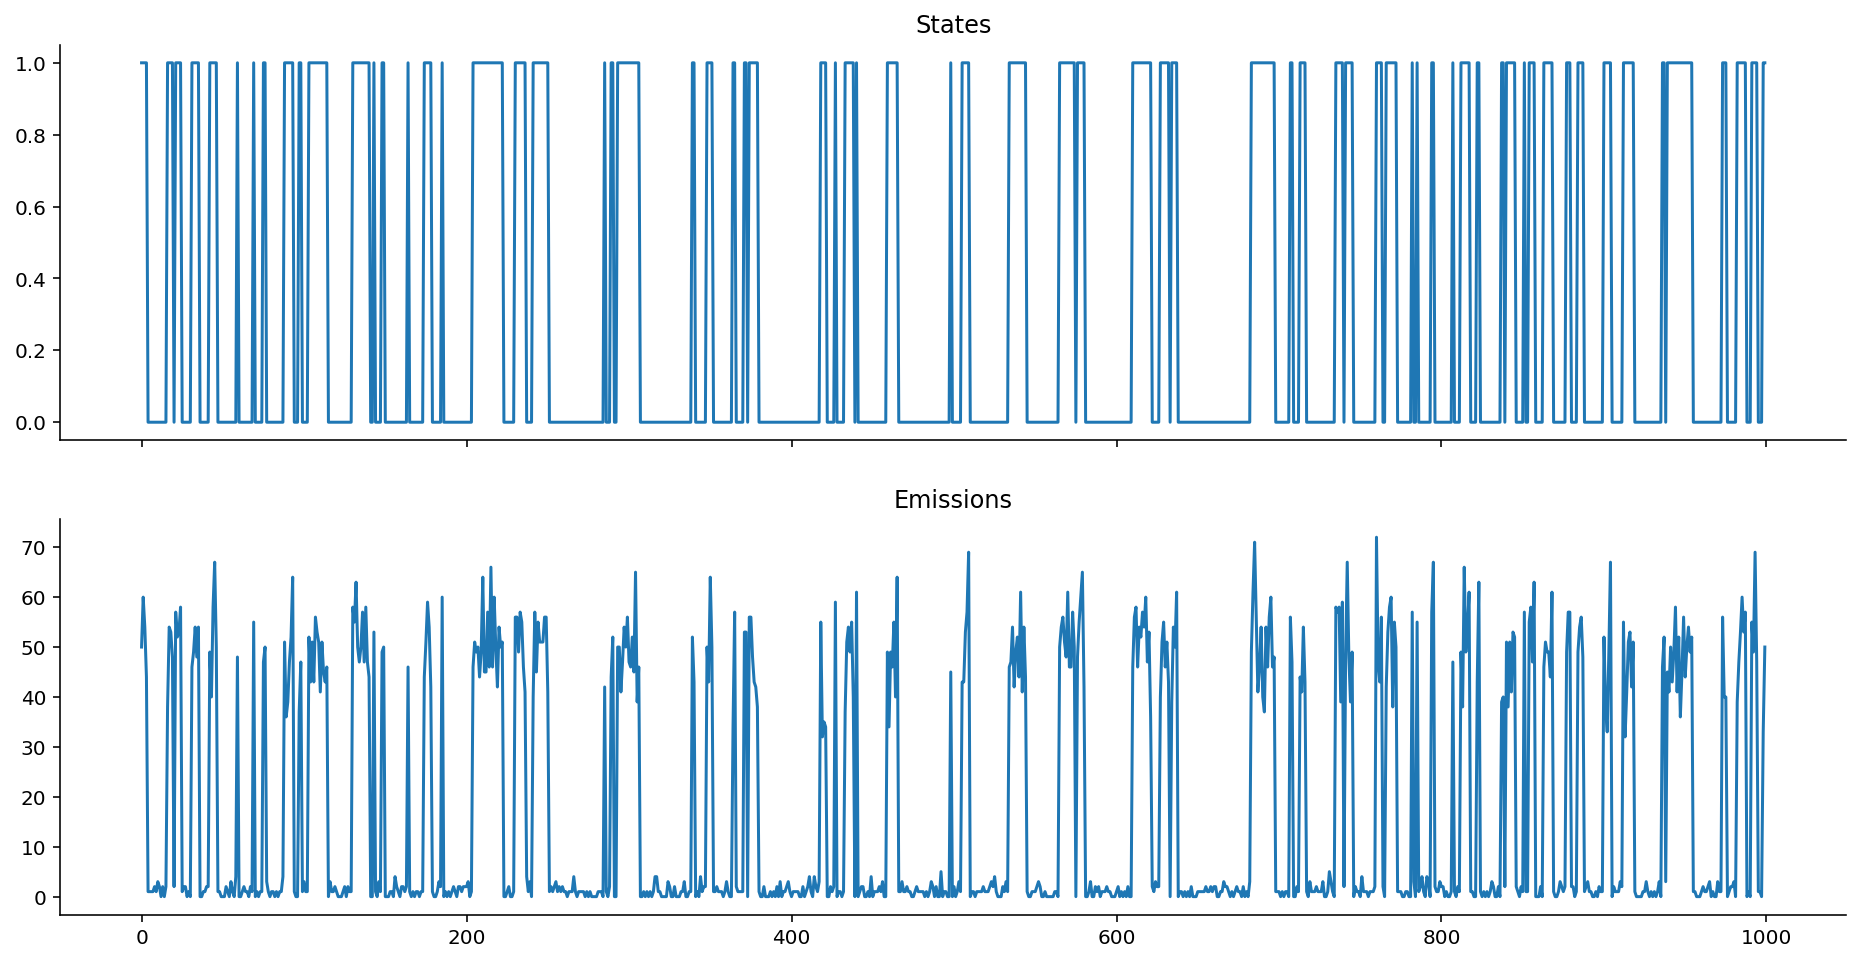

In [89]:
plot_emissions(states, poisson_ems)


## Autoregressive Gaussian HMM (heteroskedastic/homoskedastic)


In [90]:
def ar_gaussian_emissions(states: List[int], mus: List[float], k: float, sigmas: List[float]) -> List[float]:
    emissions = []
    prev_loc = 0
    for state in states:
        loc=k * prev_loc + mus[state]
        scale=sigmas[state]
        e = norm.rvs(loc=loc, scale=scale)
        emissions.append(e)
        prev_loc = e
    return emissions

In [91]:
ar_het_ems = ar_gaussian_emissions(states, mus=[0, 0], k=0, sigmas=[0.5, 0.01])

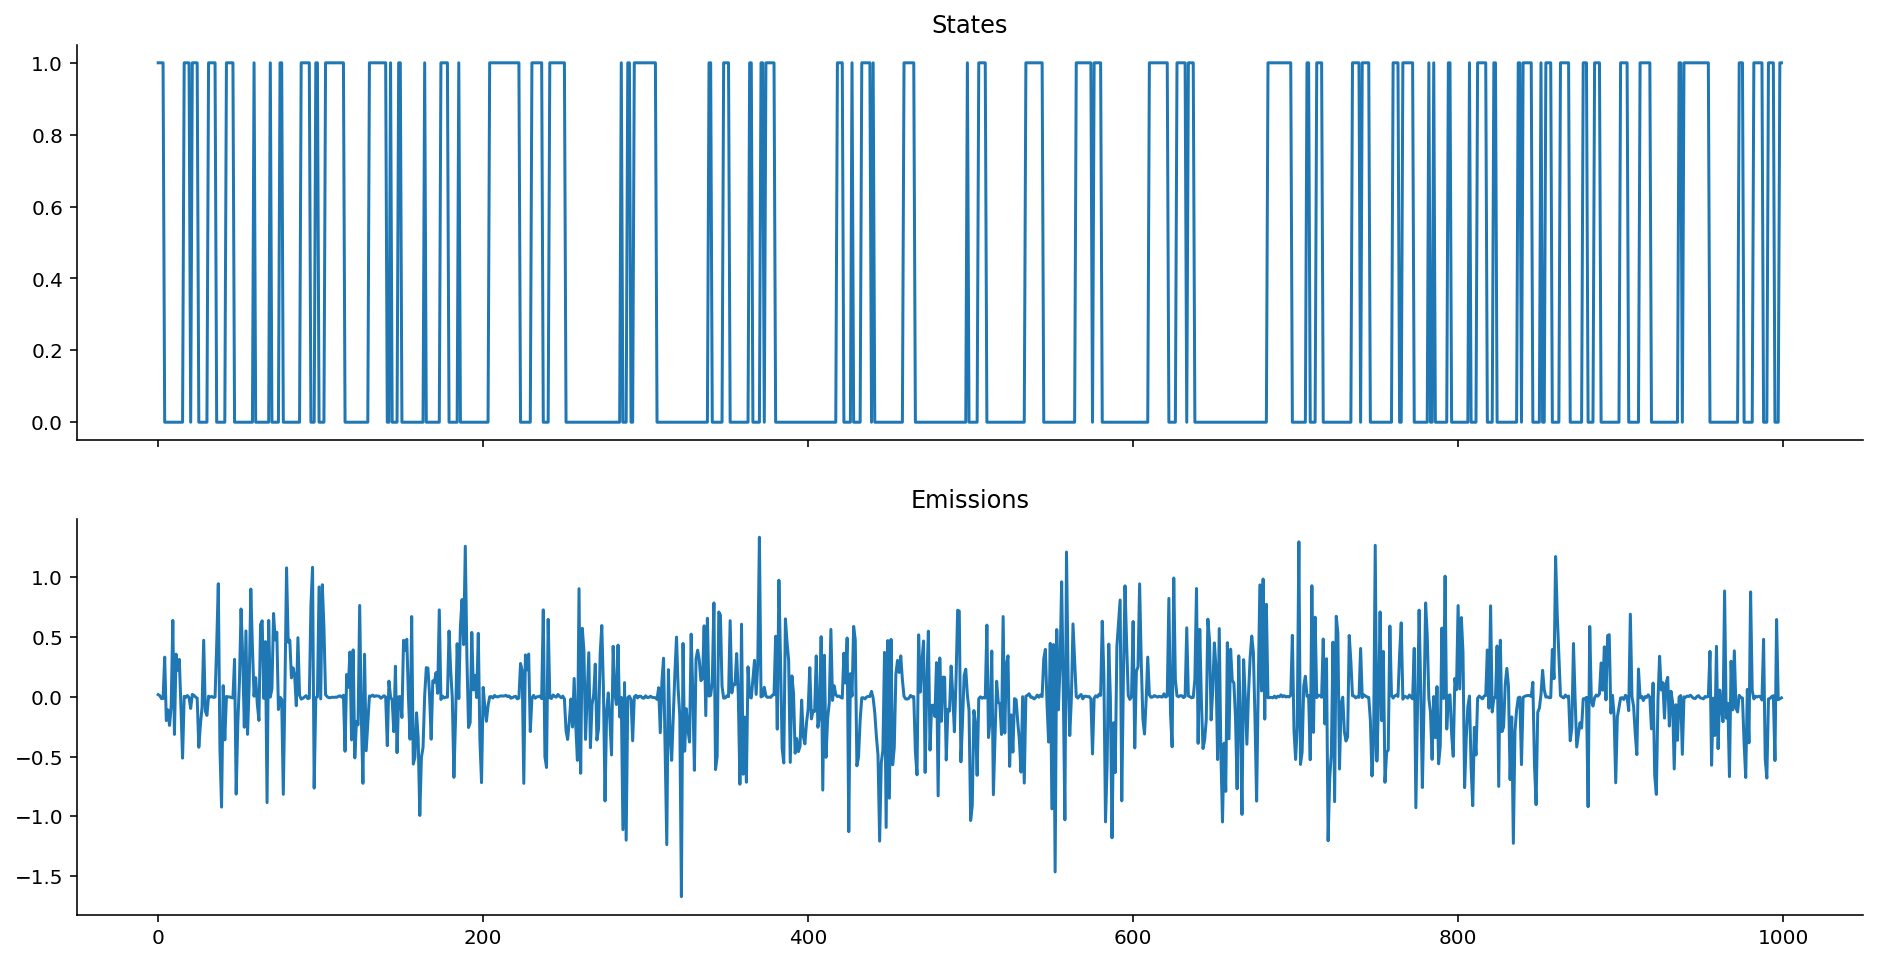

In [92]:
plot_emissions(states, ar_het_ems)

In [93]:
gaussian_ems = gaussian_emissions(states, mus=[0, 0], sigmas=[0.5, 0.01])

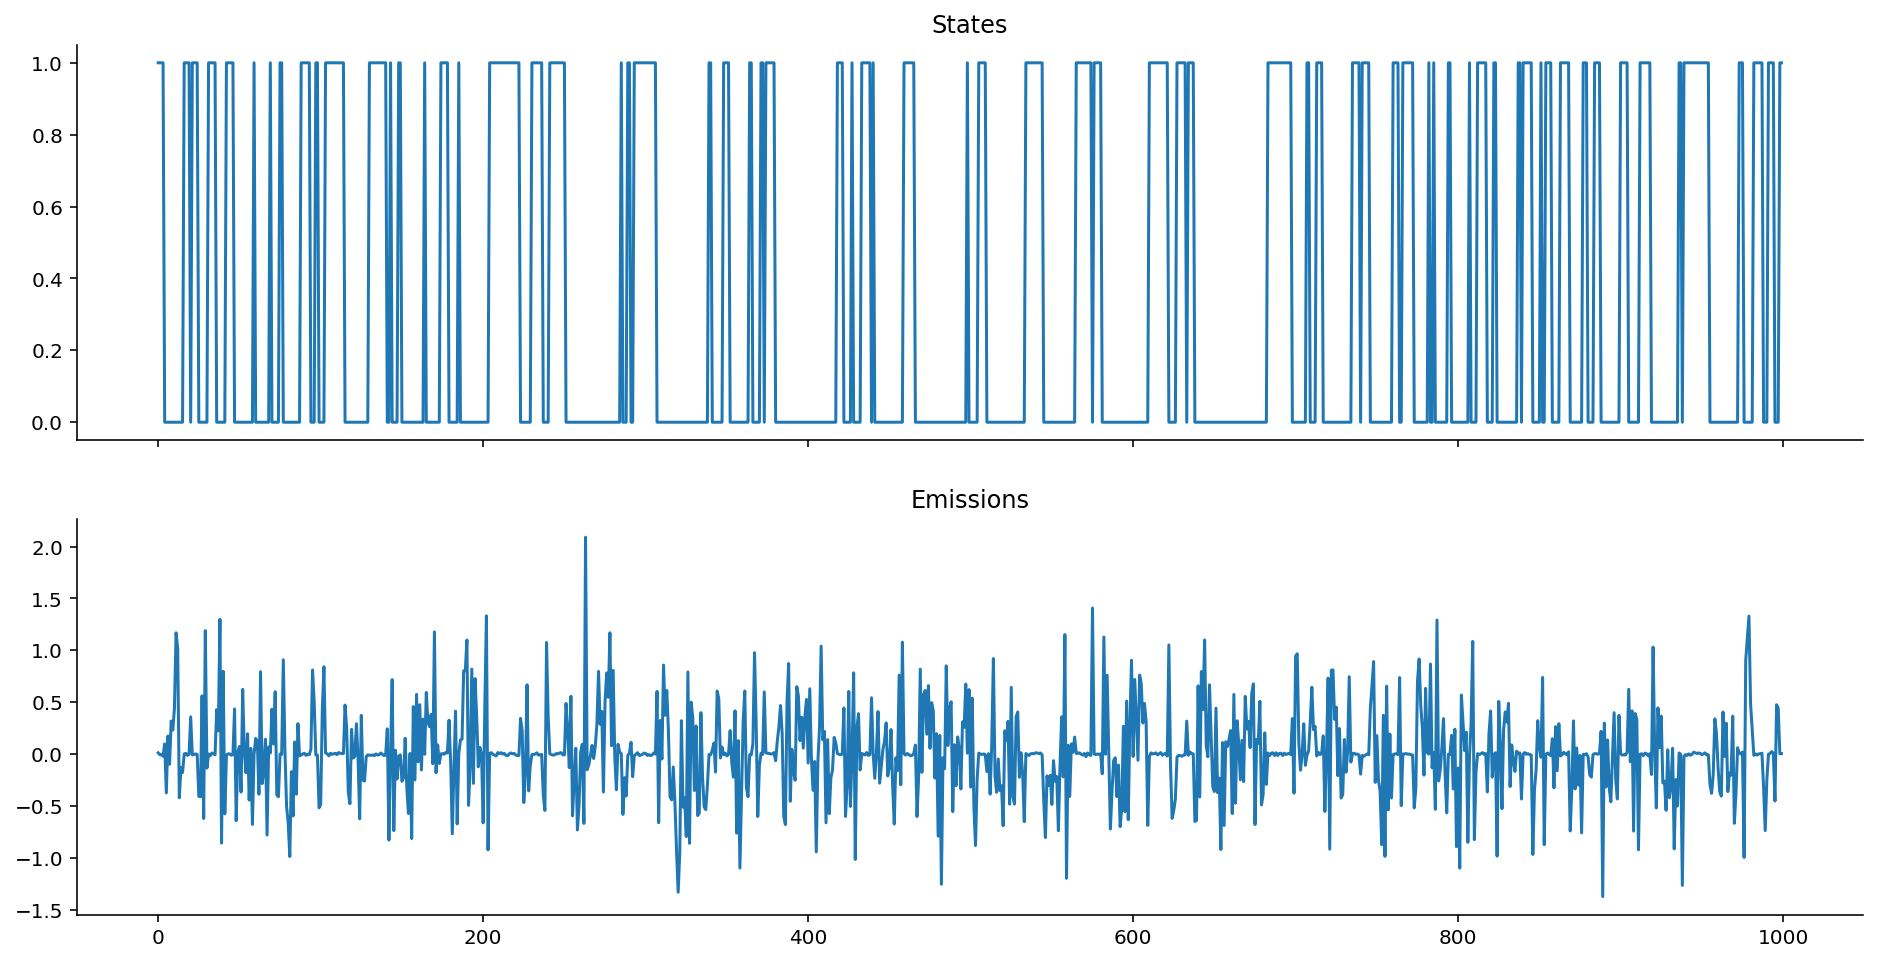

In [94]:
plot_emissions(states, gaussian_ems)

In [95]:
ar_het_ems = ar_gaussian_emissions(states, mus=[-10, 10], k=0, sigmas=[0.5, 0.01])

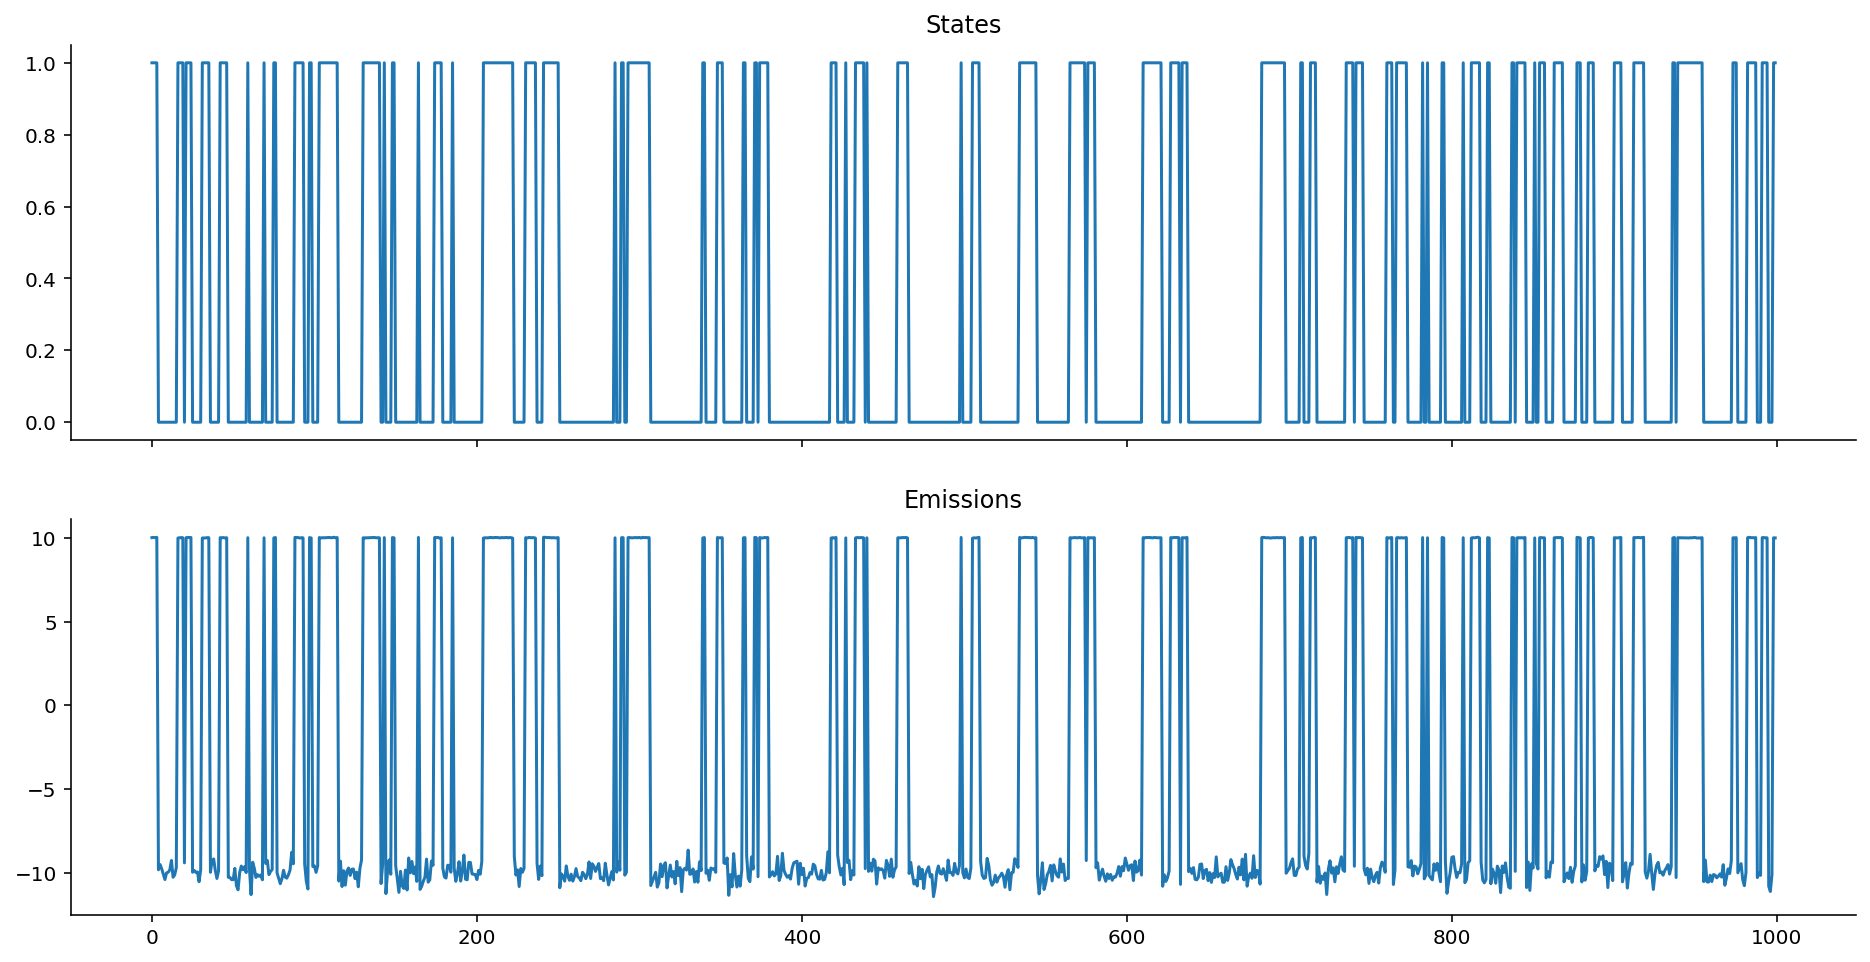

In [96]:
plot_emissions(states, ar_het_ems)

In [97]:
ar_het_ems = ar_gaussian_emissions(states, mus=[-10, 10], k=0.8, sigmas=[0.5, 0.01])

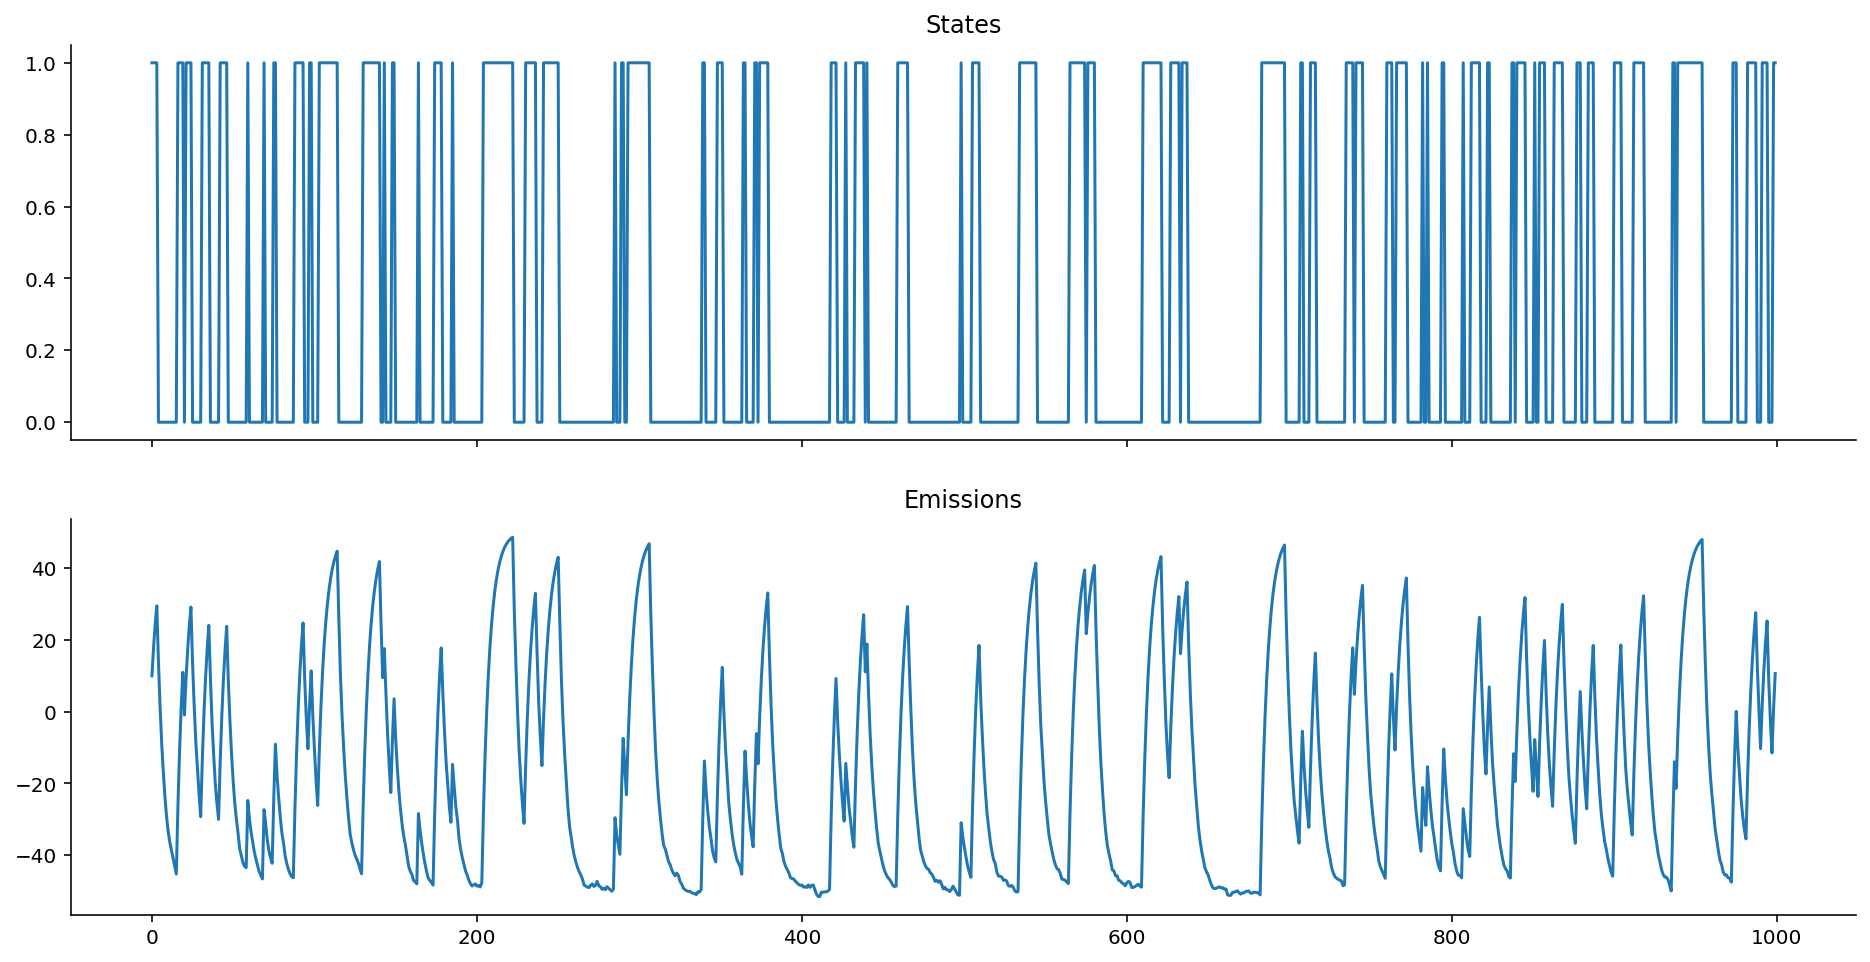

In [98]:
plot_emissions(states, ar_het_ems)

In [99]:
ar_hom_ems = ar_gaussian_emissions(states, mus=[-10, 10], k=0.8, sigmas=[1, 1])

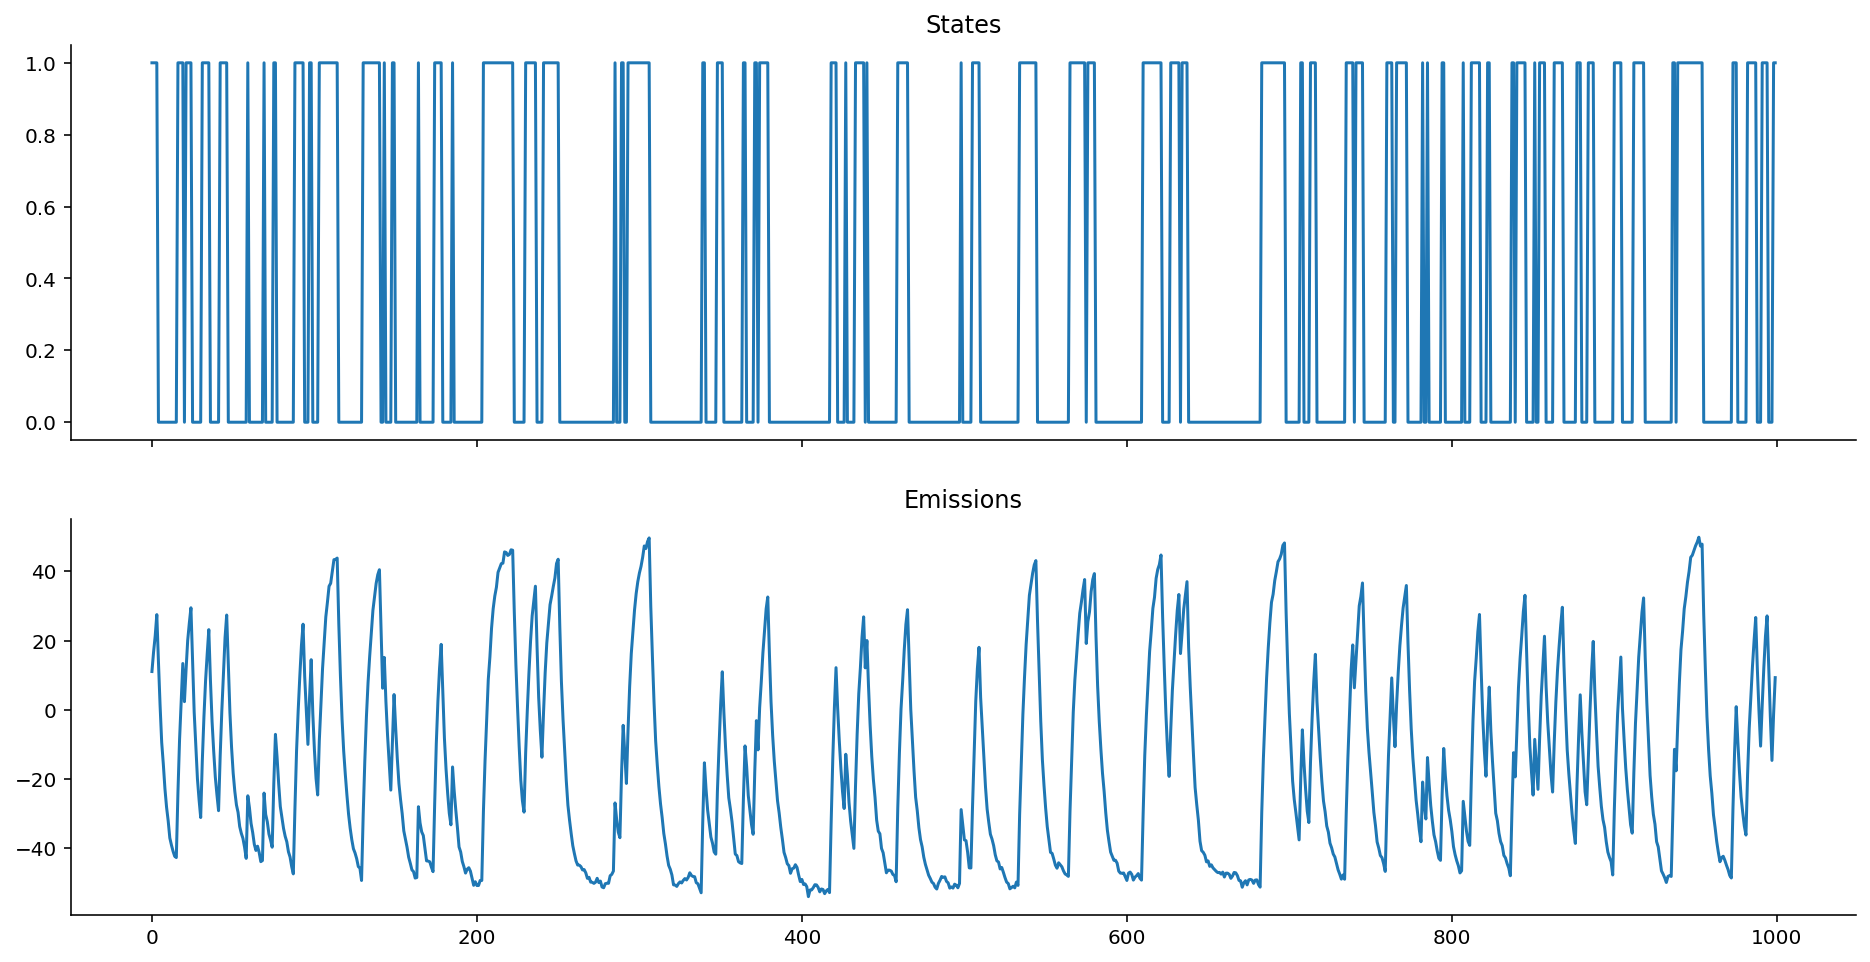

In [100]:
plot_emissions(states, ar_hom_ems)

In [101]:
gaussian_hom_ems = gaussian_emissions(states, mus=[-10, 10], sigmas=[1, 1])

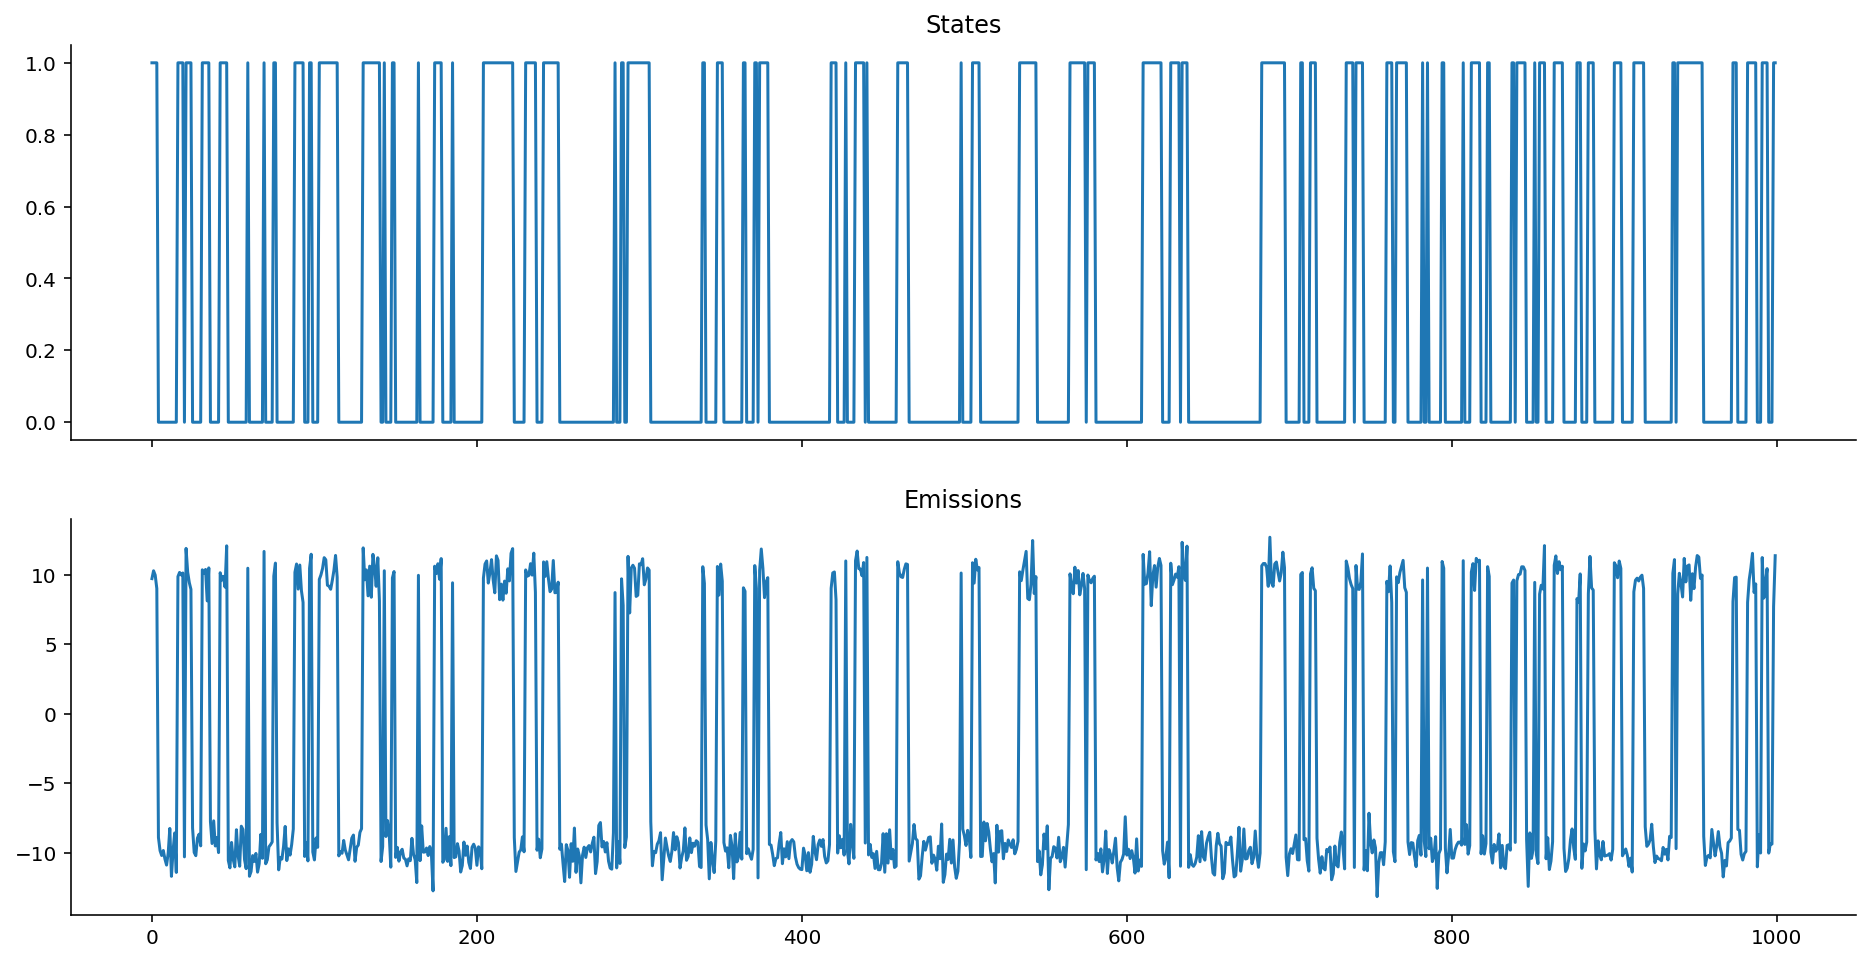

In [102]:
plot_emissions(states, gaussian_hom_ems)

# The Framework


## Markov Chain Log-Likelihood Calculation


In [113]:
p_transition, len(states)

(array([[0.9, 0.1],
        [0.2, 0.8]]),
 1000)

In [114]:
def state_logp(states, p_transition):
    logp = 0

    # states are 0, 1, 2, but we model them as [1, 0, 0], [0, 1, 0], [0, 0, 1]
    states_oh = np.eye(len(p_transition))
    for curr_state, next_state in zip(states[:-1], states[1:]):
        p_tr = p_transition[curr_state]
        logp += multinomial(n=1, p=p_tr).logpmf(states_oh[next_state])
    return logp


In [115]:
state_logp(states, p_transition)

-388.2739768664125

In [116]:
def state_logp_vect(states, p_transition):
    states_oh = np.eye(len(p_transition))
    p_tr = p_transition[states[:-1]]
    obs = states_oh[states[1:]]
    return np.sum(multinomial(n=1, p=p_tr).logpmf(obs))

In [117]:
state_logp_vect(states, p_transition)

-388.273976866416

In [118]:
def initial_logp(states, p_transition):
    initial_state = states[0]
    states_oh = np.eye(len(p_transition))
    eq_p = equilibrium_distribution(p_transition)
    return (multinomial(n=1, p=eq_p).logpmf(states_oh[initial_state].squeeze()))

In [119]:
initial_logp(states, p_transition)

array(-1.09861229)

In [120]:
def markov_state_logp(states, p_transition):
    return (state_logp_vect(states, p_transition)+ initial_logp(states, p_transition))

In [121]:
markov_state_logp(states, p_transition)

-389.3725891550841

## Markov Chain with Gaussian Emissions Log-Likelihood Calculation


In [130]:
def gaussian_logp(states, mus, sigmas, emissions):
    logp = 0
    for (emission, state) in zip(emissions, states):
        logp += norm(mus[state], sigmas[state]).logpdf(emission)
    return logp

In [131]:
gaussian_logp(states, mus=[-10, 10], sigmas=[1., 0.01], emissions=gaussian_ems)

-167579129.76595628

In [132]:
def gaussian_logp_vect(states, mus, sigmas, emissions):
    mu = mus[states]
    sigma = sigmas[states]
    return np.sum(norm(mu, sigma).logpdf(emissions))

In [133]:
gaussian_logp_vect(states, mus=np.array([-10, 10]), sigmas=np.array([1., 0.01]), emissions=gaussian_ems)

-167579129.76595592

In [134]:
def gaussian_emission_hmm_logp(states, p_transition, mus, sigmas, emissions):
    return markov_state_logp(states, p_transition) + gaussian_logp_vect(states, mus, sigmas, emissions)

In [135]:
gaussian_emission_hmm_logp(states, p_transition, mus=np.array([-10,  10]), sigmas=np.array([1., 0.01]), emissions=gaussian_ems)

-167579519.13854507

## Markov Chain with Autoregressive Gaussian Emissions Log-Likelihood Calculation

In [136]:
def ar_gaussian_emissions(states: List[int], mus: List[float], k: float, sigmas: List[float]) -> List[float]:
    emissions = []
    prev_loc = 0
    for state in states:
        loc=k * prev_loc + mus[state]
        scale=sigmas[state]
        e = norm.rvs(loc=loc, scale=scale)
        emissions.append(e)
        prev_loc = e
    return emissions

In [137]:
def ar_gaussian_homoskedastic_emissions(states: List[int], k: float, mus: List[float]) -> List[float]:
    emissions = []
    prev_loc = 0
    for state in states:
        e = norm.rvs(loc=k * prev_loc + mus[state], scale=1)
        emissions.append(e)
        prev_loc = e
    return emissions

In [138]:
def ar_gaussian_heteroskedastic_emissions(states: List[int], k: float, sigmas: List[float]) -> List[float]:
    emissions = []
    prev_loc = 0
    for state in states:
        e = norm.rvs(loc=k * prev_loc, scale=sigmas[state])
        emissions.append(e)
        prev_loc = e
    return emissions

In [139]:
def ar_gaussian_emissions_logp(states, k, mus, sigmas, emissions):
    logp = 0
    initial_state = states[0]
    initial_emission_logp = norm(0, sigmas[initial_state]).logpdf(emissions[0])
    for previous_emission, current_emission, state in zip(emissions[:-1], emissions[1:], states[1:]):
        loc = k * previous_emission+mus[state]
        scale = sigmas[state]
        logp += norm(loc, scale).logpdf(current_emission)
    return logp

In [140]:
def ar_gausian_hmm_logp(states, p_transition, k, mus, sigmas, emissions):
    return ( markov_state_logp(states, p_transition) + 
            ar_gaussian_emissions_logp(states, k, mus, sigmas, emissions))

In [141]:
def ar_gaussian_heteroskedastic_emissions_logp(states, k, sigmas, emissions):
    logp = 0
    initial_state = states[0]
    initial_emission_logp = norm(0, sigmas[initial_state]).logpdf(emissions[0])
    for previous_emission, current_emission, state in zip(emissions[:-1], emissions[1:], states[1:]):
        loc = k * previous_emission
        scale = sigmas[state]
        logp += norm(loc, scale).logpdf(current_emission)
    return logp

In [142]:
def ar_gausian_heteroskedastic_hmm_logp(states, p_transition, k, sigmas, emissions):
    return ( markov_state_logp(states, p_transition) + 
            ar_gaussian_heteroskedastic_emissions_logp(states, k, sigmas, emissions))

In [143]:
ar_ems = ar_gaussian_emissions(states, k=1., mus=[0, 0], sigmas=[0.5, 0.01])

In [144]:
ar_gaussian_emissions_logp(states, k=1.0, mus=[0, 0], sigmas=[0.5, 0.01], emissions=ar_ems)

567.377858889903

In [145]:
ar_gausian_hmm_logp(states, p_transition, k=1.0, mus=[0, 0], sigmas=[0.5,  0.01], emissions=ar_ems)

178.0052697348189

In [146]:
ar_het_ems = ar_gaussian_heteroskedastic_emissions(states, k=1., sigmas=[0.5,  0.01])

In [147]:
ar_gaussian_heteroskedastic_emissions_logp(states, k=1.0, sigmas=[0.5,  0.01], emissions=ar_het_ems)

580.5916761165042

In [148]:
ar_gausian_heteroskedastic_hmm_logp(states, p_transition, k=1.0, sigmas=[0.5,  0.01], emissions=ar_het_ems)

191.21908696142015

# HMM States Distribution


In [160]:
def solve_equilibrium(n_states, p_transition):
    A = tt.dmatrix('A')
    A = tt.eye(n_states) - p_transition + tt.ones(shape=(n_states, n_states))
    p_equilibrium = pm.Deterministic("p_equilibrium", sla.solve(A.T, tt.ones(shape=(n_states))))
    return p_equilibrium

In [161]:
class HMMStates(pm.Categorical):
    """
    Hidden Markov Model States
    Parameters
    ----------
    p_transition : tensor
        transition probability
        shape = (n_states,n_states)
        
    p_equilibrium : tensor
         equilibrium probabilities
         shape = _states)
    
    """
    def __init__(self, p_transition, p_equilibrium, n_states, *args, **kwargs):
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.p_transition = p_transition
        self.p_equilibrium = p_equilibrium
        self.k = n_states
        self.mode = tt.cast(0,dtype='int64')

        
    def logp(self, x):
        p_eq = self.p_equilibrium
        # Broadcast out the transition probabilities,
        # so that we can broadcast the calculation
        # of log-likelihoods
        p_tr = self.p_transition[x[:-1]]

        # the logp of the initial state evaluated against the equilibrium probabilities
        initial_state_logp = pm.Categorical.dist(p_eq).logp(x[0])

        # the logp of the rest of the states.
        x_i = x[1:]
        ou_like = pm.Categorical.dist(p_tr).logp(x_i)
        transition_logp = tt.sum(ou_like)
        return initial_state_logp + transition_logp

In [162]:
class HMMGaussianEmissions(pm.Continuous):
    def __init__(self, states, mu, sigma, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.states = states
        # self.rate = rate
        self.mu = mu
        self.sigma = sigma

    def logp(self, x):
        """
        x: observations
        """
        states = self.states
        # rate = self.rate[states]  # broadcast the rate across the states.
        mu = self.mu[states]
        sigma = self.sigma[states]
        return tt.sum(pm.Normal.dist(mu=mu, sigma=sigma).logp(x))

In [176]:
p_transition_true=np.array([[0.9, 0.1],
       [0.2, 0.8]])

In [177]:
p_transition_true

array([[0.9, 0.1],
       [0.2, 0.8]])

In [164]:
gaussian_hom_ems = gaussian_emissions(states, mus=[-10, 10], sigmas=[1, .01])

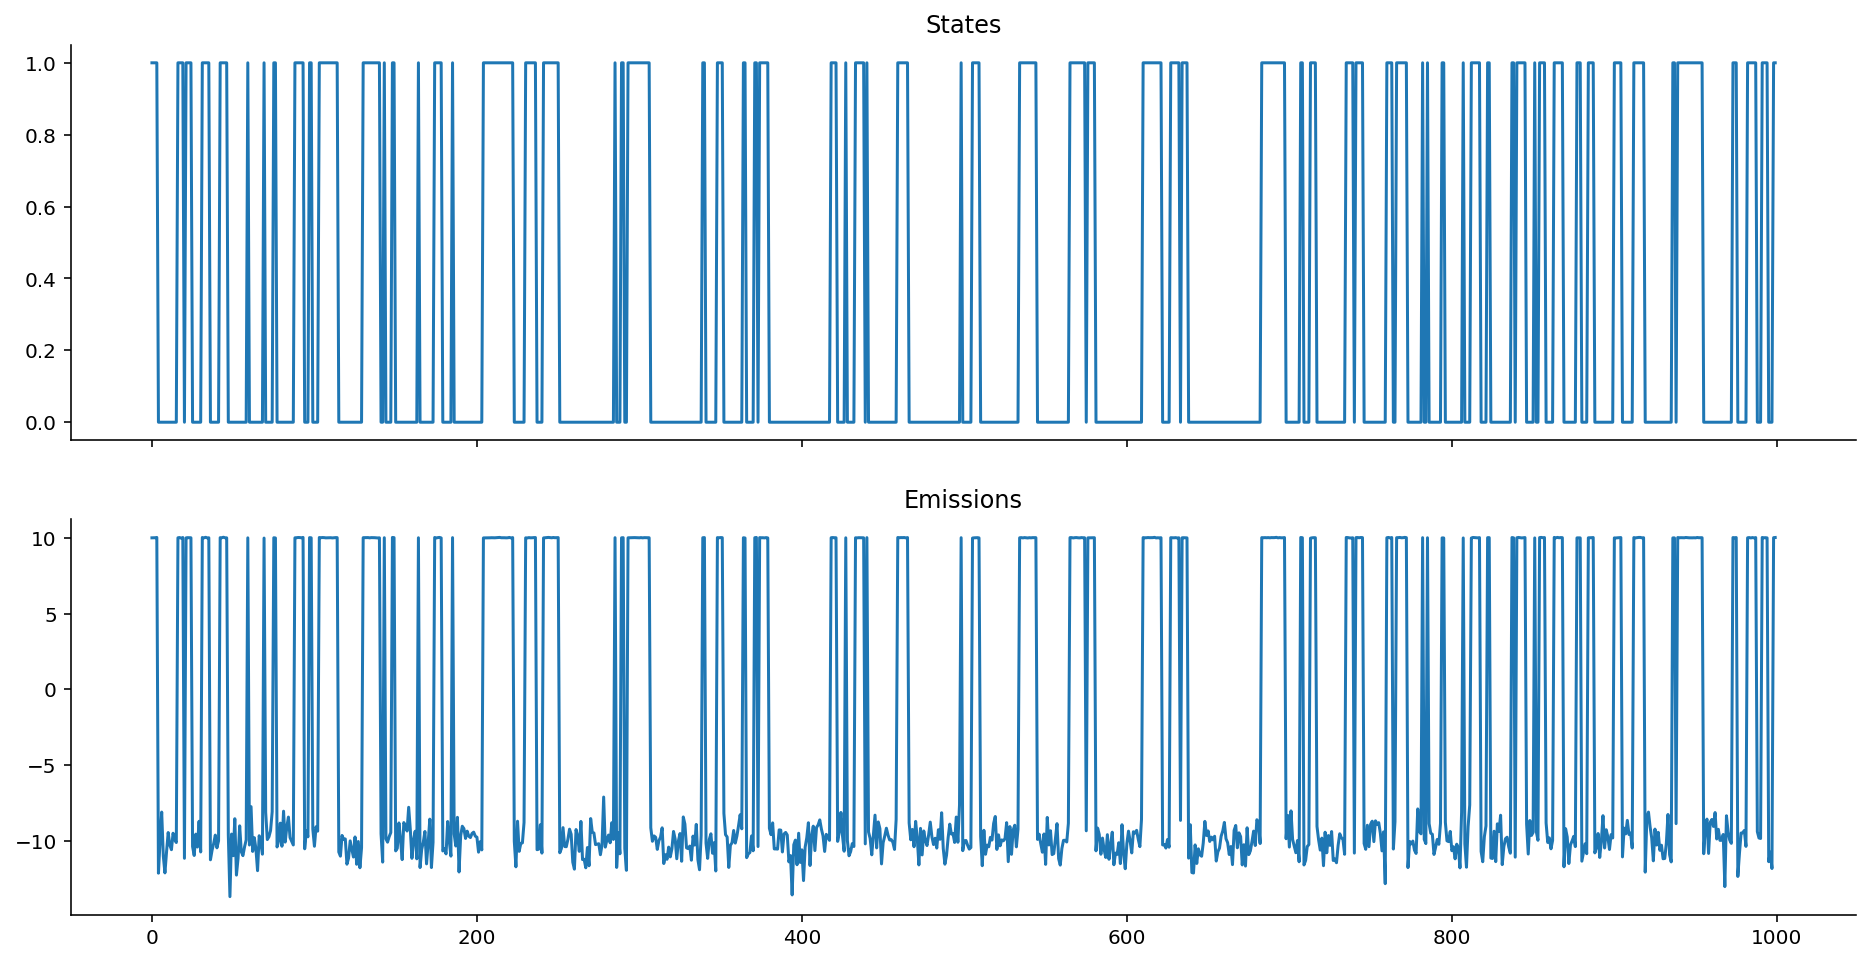

In [165]:
plot_emissions(states, gaussian_hom_ems)

In [167]:
n_states = 2

In [168]:
basic_model = pm.Model()

with basic_model:

    p_transition = pm.Dirichlet("p_transition",a=tt.ones((n_states, n_states)), shape=(n_states, n_states))

    p_equilibrium = solve_equilibrium(n_states, p_transition) # Solve for the equilibrium state

    obs_states = HMMStates("states", p_transition=p_transition,p_equilibrium=p_equilibrium,n_states=n_states,observed=np.array(states).astype("float"))

In [169]:
%%time
with basic_model:
    trace = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_transition]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:14<00:00, 561.88draws/s]


CPU times: user 8.54 s, sys: 1.02 s, total: 9.56 s
Wall time: 30.2 s


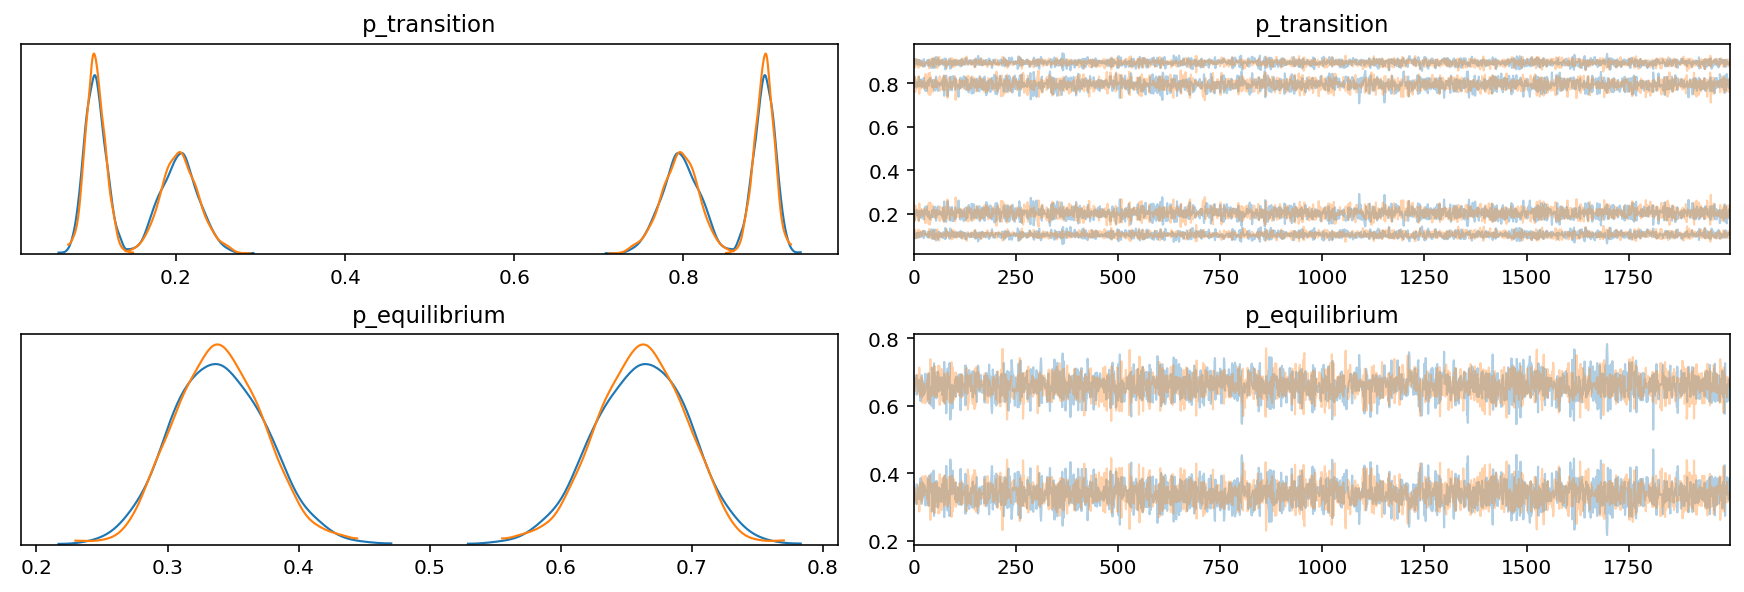

In [170]:
pm.traceplot(trace)
plt.show()

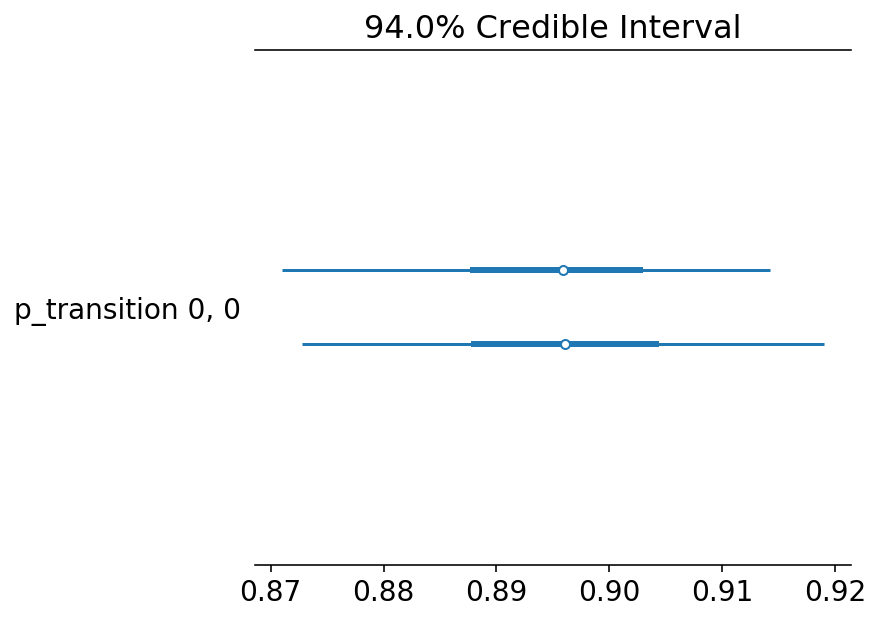

In [171]:
az.plot_forest(trace, var_names=["p_transition"]);

In [181]:
p_transition_est=np.asarray(trace.get_values('p_transition', burn=0, combine=True))
p_transition_mean=np.mean(p_transition_est, axis=0)

In [183]:
p_transition_true, p_transition_mean

(array([[0.9, 0.1],
        [0.2, 0.8]]),
 array([[0.89548306, 0.10451694],
        [0.20443125, 0.79556875]]))

In [184]:
basic_model = pm.Model()

with basic_model:
    # Priors for transition matrix
    p_transition = pm.Dirichlet("p_transition", a=tt.ones((n_states, n_states)), shape=(n_states, n_states))

    # Solve for the equilibrium state
    p_equilibrium = solve_equilibrium(n_states, p_transition)

    # HMM state
    hmm_states = HMMStates("hmm_states", p_transition=p_transition, p_equilibrium=p_equilibrium,n_states=n_states,shape=(len(gaussian_ems),))

    # Prior for mu and sigma
    mu = pm.Normal("mu", mu=0, sigma=1, shape=(n_states,))
    sigma = pm.Exponential("sigma", lam=2, shape=(n_states,))

    # Observed emission likelihood
    obs = HMMGaussianEmissions( "emission", states=hmm_states, mu=mu, sigma=sigma, observed=gaussian_ems)

In [185]:
%%time
with basic_model:
    trace = pm.sample(draws=2000, tune=2000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sigma, mu, p_transition]
>BinaryGibbsMetropolis: [hmm_states]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [15:20<00:00,  8.69draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 23.6 s, sys: 2.46 s, total: 26.1 s
Wall time: 15min 35s


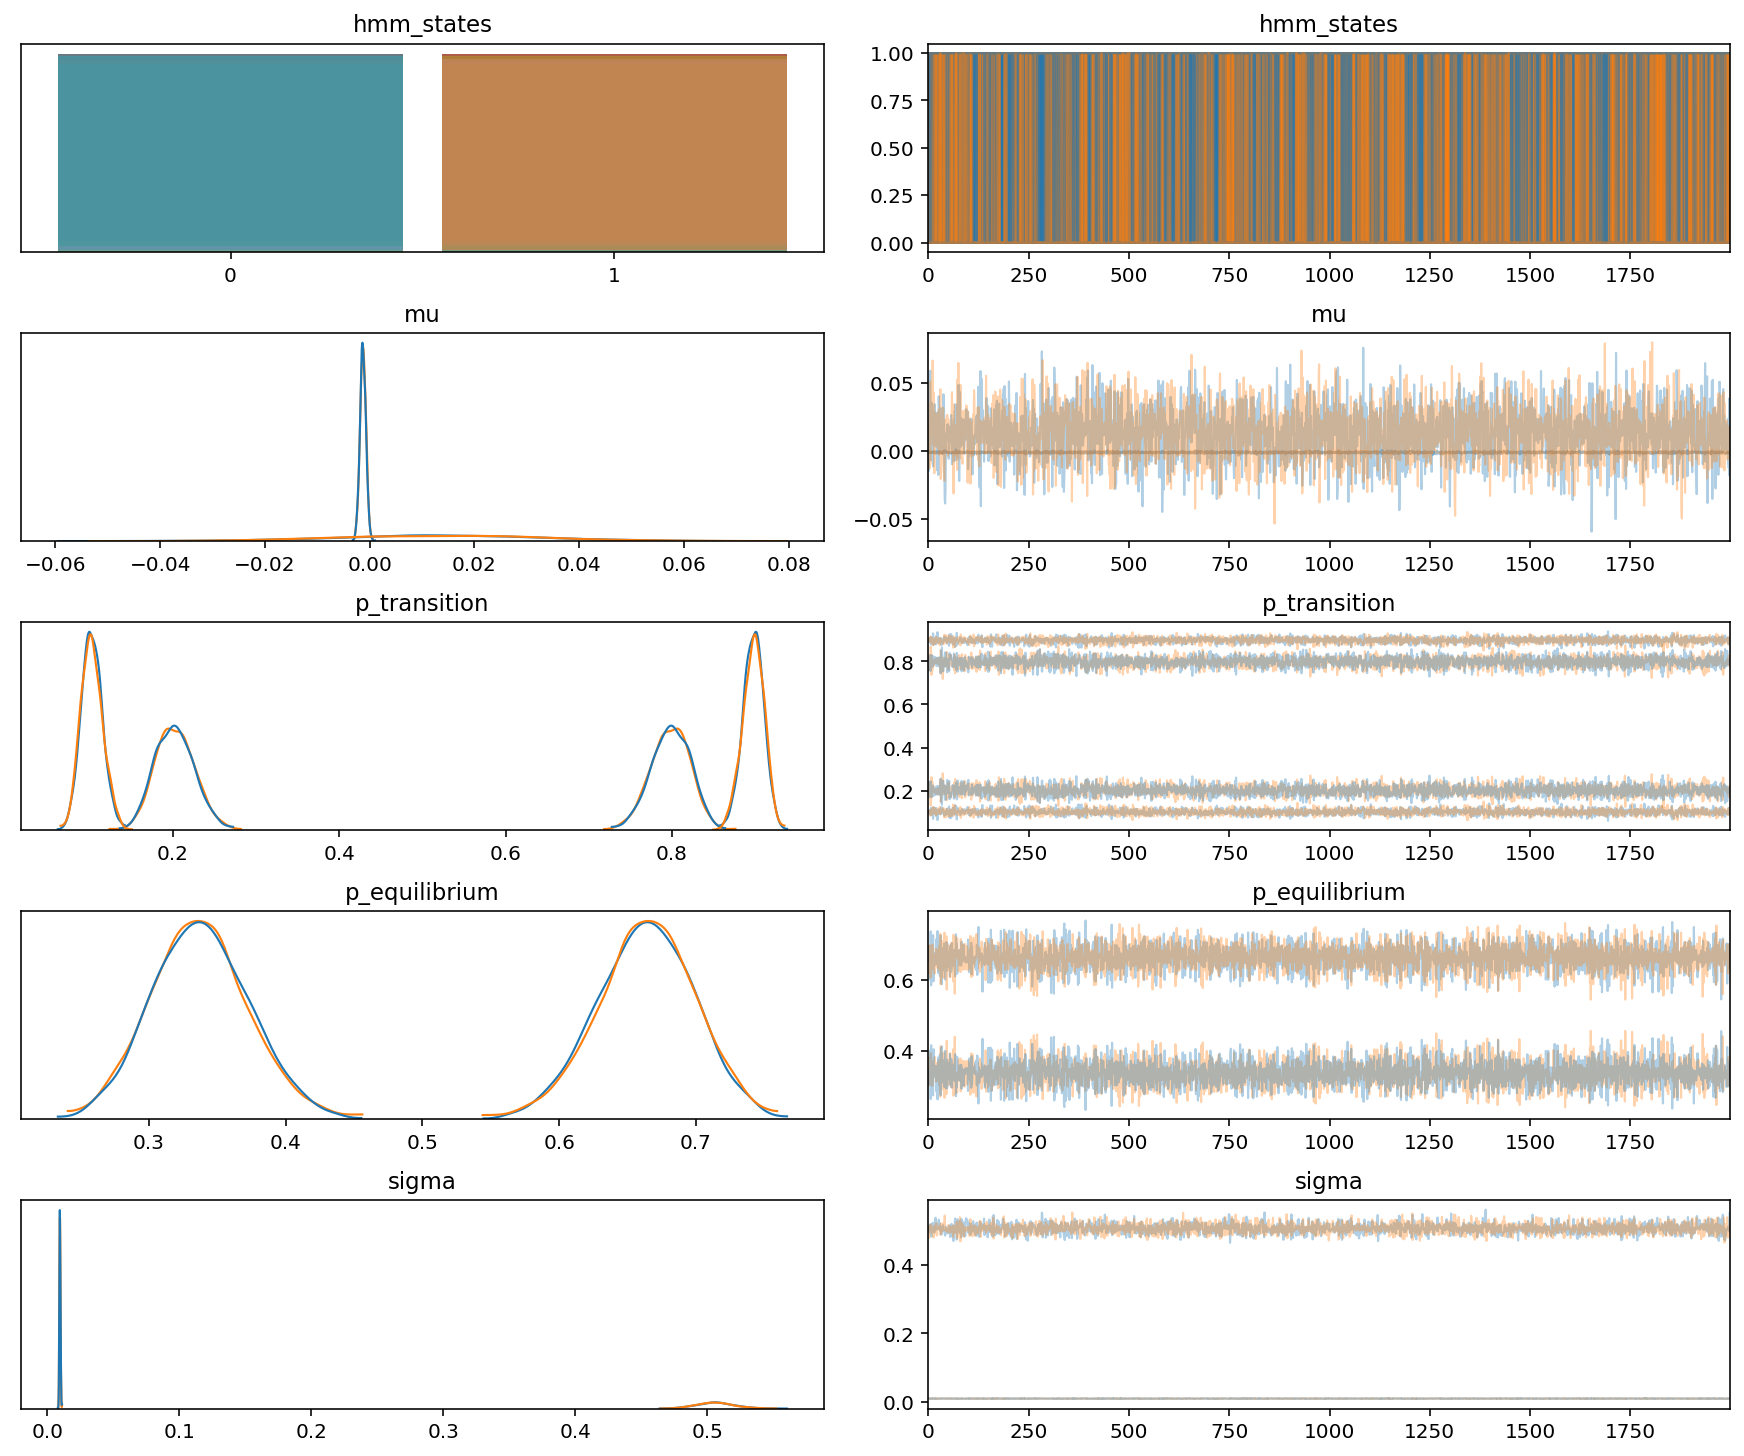

In [186]:
pm.traceplot(trace)
plt.show()

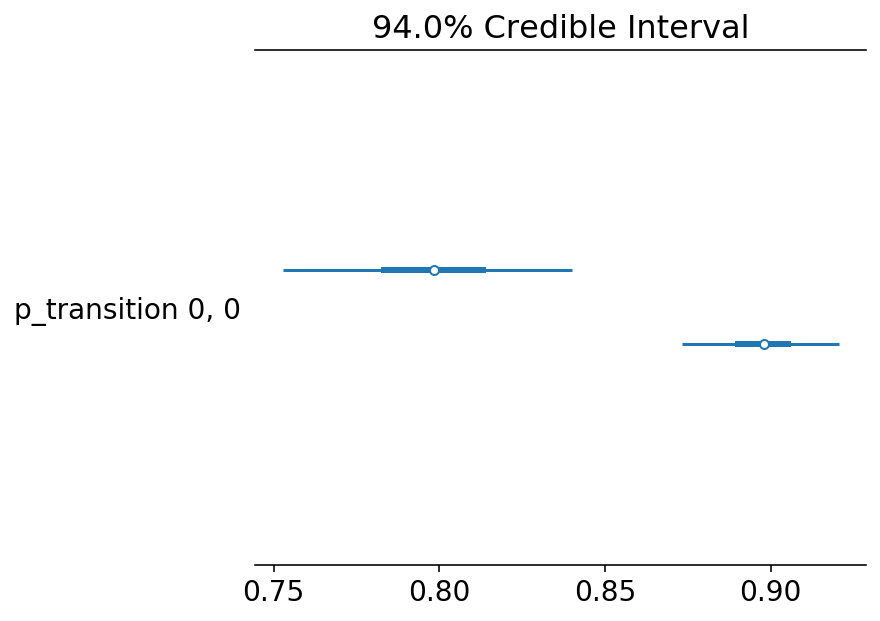

In [187]:
az.plot_forest(trace, var_names=["p_transition"]);

In [188]:
p_transition_est=np.asarray(trace.get_values('p_transition', burn=0, combine=True))
p_transition_mean=np.mean(p_transition_est, axis=0)

In [189]:
p_transition_true, p_transition_mean

(array([[0.9, 0.1],
        [0.2, 0.8]]),
 array([[0.84764593, 0.15235407],
        [0.15195789, 0.84804211]]))

In [191]:
mu_est=np.asarray(trace.get_values('mu', burn=0, combine=True))
mu_mean=np.mean(mu_est, axis=0)

In [192]:
mu_mean

array([0.00588136, 0.00588172])

# Autoregressive HMMs with Gaussian Emissions


In [200]:
class ARHMMGaussianEmissions_centered(pm.Continuous):
    def __init__(self, states, mu, k, sigma, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.states = states
        self.sigma = sigma  # variance
        self.k = k  # autoregressive coefficient.

    def logp(self, x):
        """
        x: observations
        """
        states = self.states
        sigma = self.sigma[states]
        k = self.k

        ar_mean = k * x[:-1]
        ar_like = tt.sum(pm.Normal.dist(mu=ar_mean, sigma=sigma[1:]).logp(x[1:]))

        boundary_like = pm.Normal.dist(mu=0, sigma=sigma[0]).logp(x[0])
        return ar_like + boundary_like

In [193]:
class ARHMMGaussianEmissions(pm.Continuous):
    def __init__(self, states, mu, k, sigma, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.states = states
        self.mu = mu
        self.sigma = sigma  # variance
        self.k = k  # autoregressive coefficient.

    def logp(self, x):
        """
        x: observations
        """
        states = self.states
        mu = self.mu[states]
        sigma = self.sigma[states]
        k = self.k

        ar_mean = k * x[:-1]
        ar_like = tt.sum(pm.Normal.dist(mu=ar_mean, sigma=sigma[1:]).logp(x[1:]))

        boundary_like = pm.Normal.dist(mu=mu, sigma=sigma[0]).logp(x[0])
        return ar_like + boundary_like

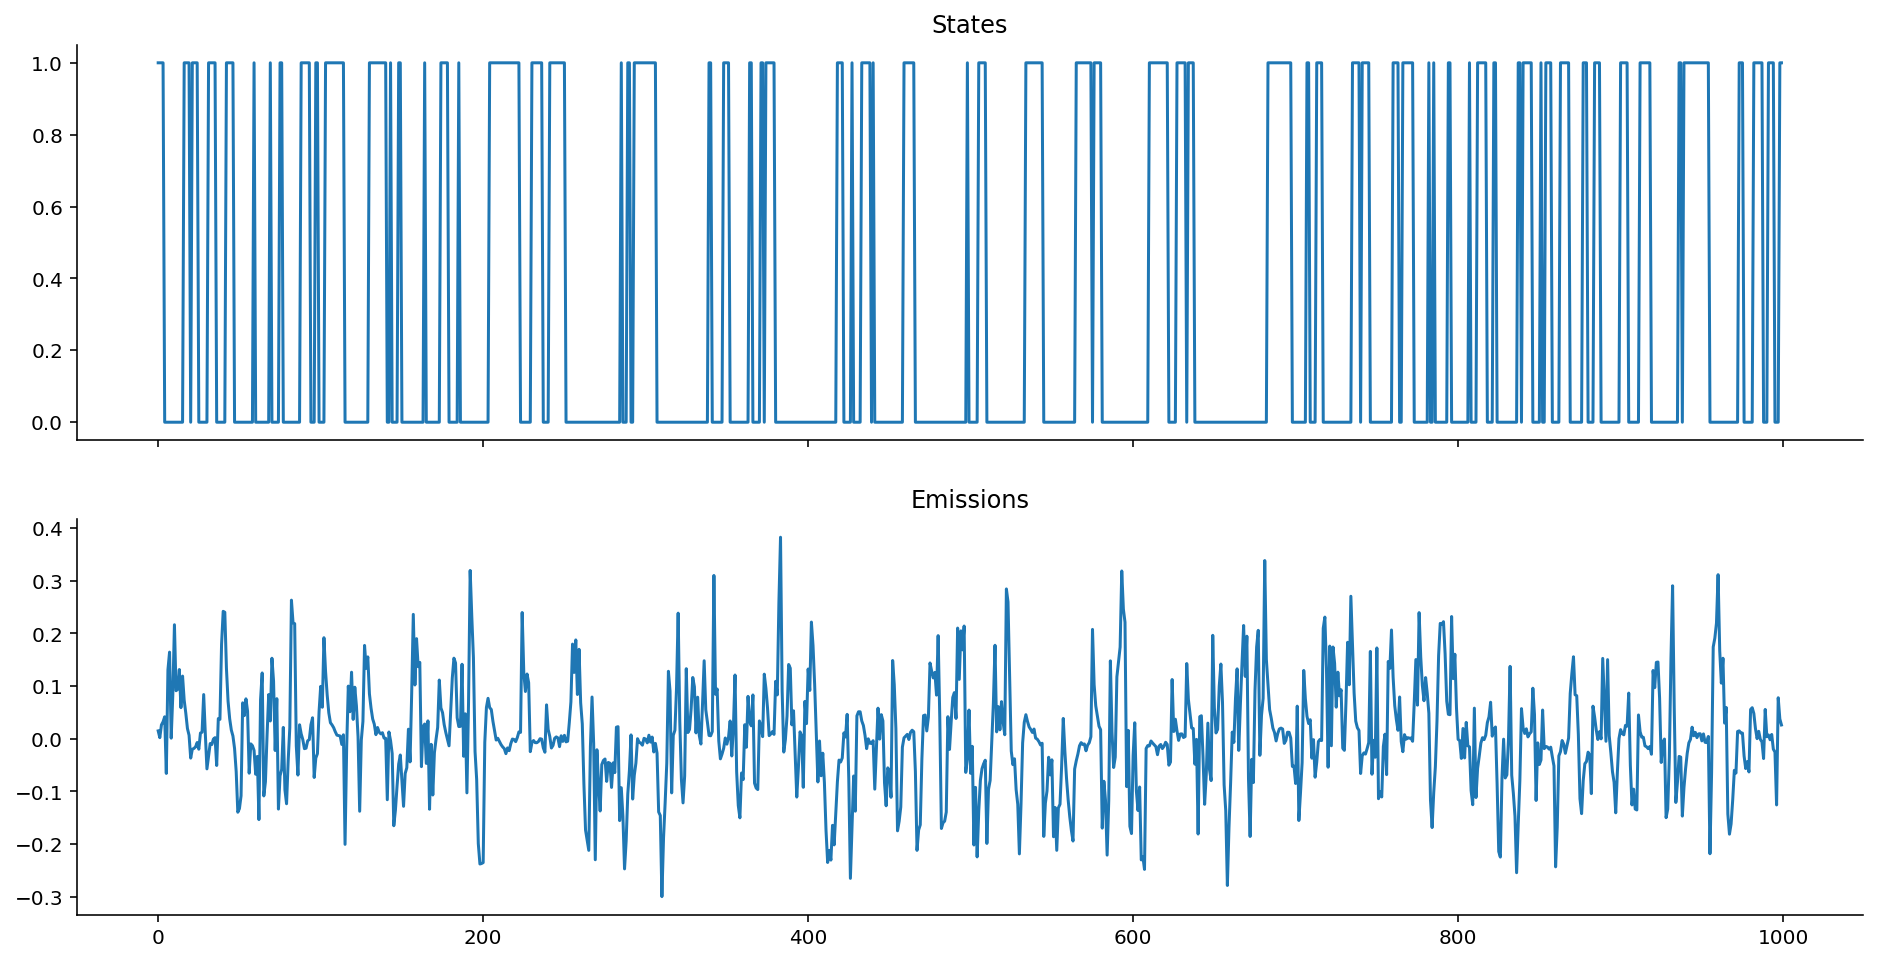

In [196]:
ar_het_ems = ar_gaussian_heteroskedastic_emissions(states, k=0.6, sigmas=[0.1, 0.01])
plot_emissions(states, ar_het_ems)

In [198]:
basic_model = pm.Model()

with basic_model:
    # Priors for transition matrix
    p_transition = pm.Dirichlet("p_transition", a=tt.ones((n_states, n_states)), shape=(n_states, n_states))

    # Solve for the equilibrium state
    p_equilibrium = solve_equilibrium(n_states, p_transition)

    # HMM state
    hmm_states = HMMStates("hmm_states", p_transition=p_transition, p_equilibrium=p_equilibrium,n_states=n_states,shape=(len(gaussian_ems),))

    # Prior for mu and sigma
    mu = pm.Normal("mu", mu=0, sigma=1, shape=(n_states,))
    sigma = pm.Exponential("sigma", lam=2, shape=(n_states,))
    k = pm.Beta("k", alpha=2, beta=2) # a not-so-weak prior for k

    # Observed emission likelihood
    obs = ARHMMGaussianEmissions( "emission", states=hmm_states,  mu=mu, k=k, sigma=sigma, observed=ar_het_ems)

In [199]:
%%time
with basic_model:
    trace = pm.sample(draws=2000, tune=2000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [k, sigma, mu, p_transition]
>BinaryGibbsMetropolis: [hmm_states]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [17:52<00:00,  7.46draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 19.4 s, sys: 3.31 s, total: 22.7 s
Wall time: 18min 17s


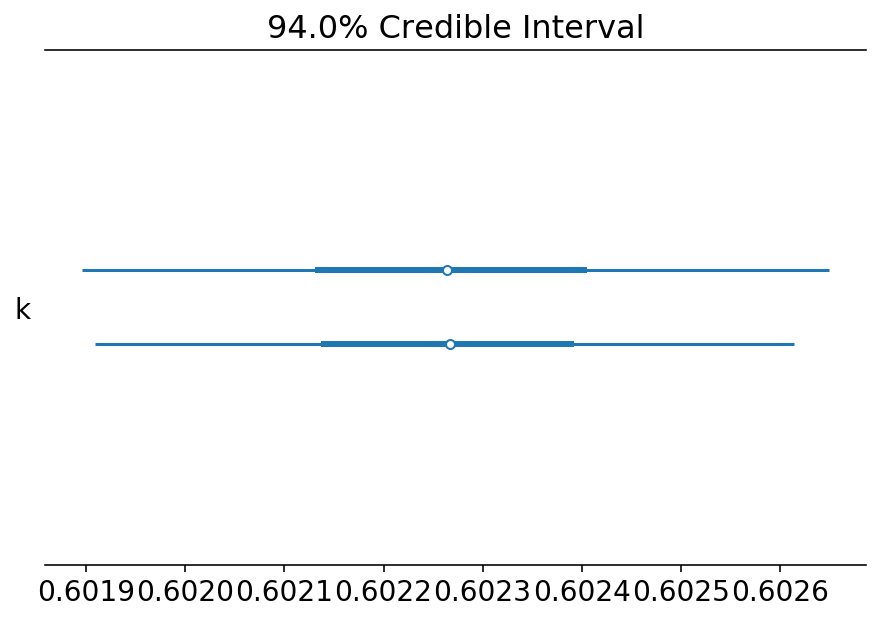

In [201]:
az.plot_forest(trace, var_names=["k"]);

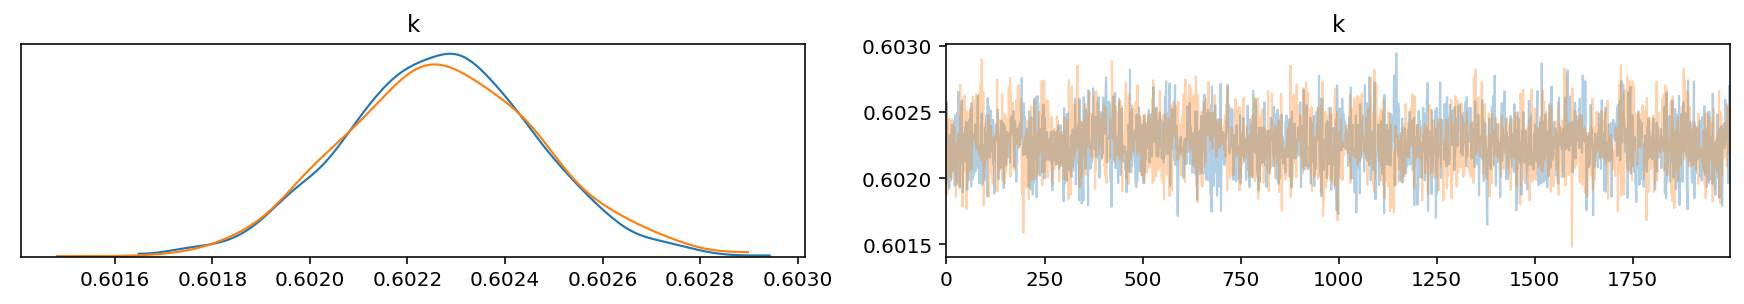

In [202]:
az.plot_trace(trace, var_names=["k"]);

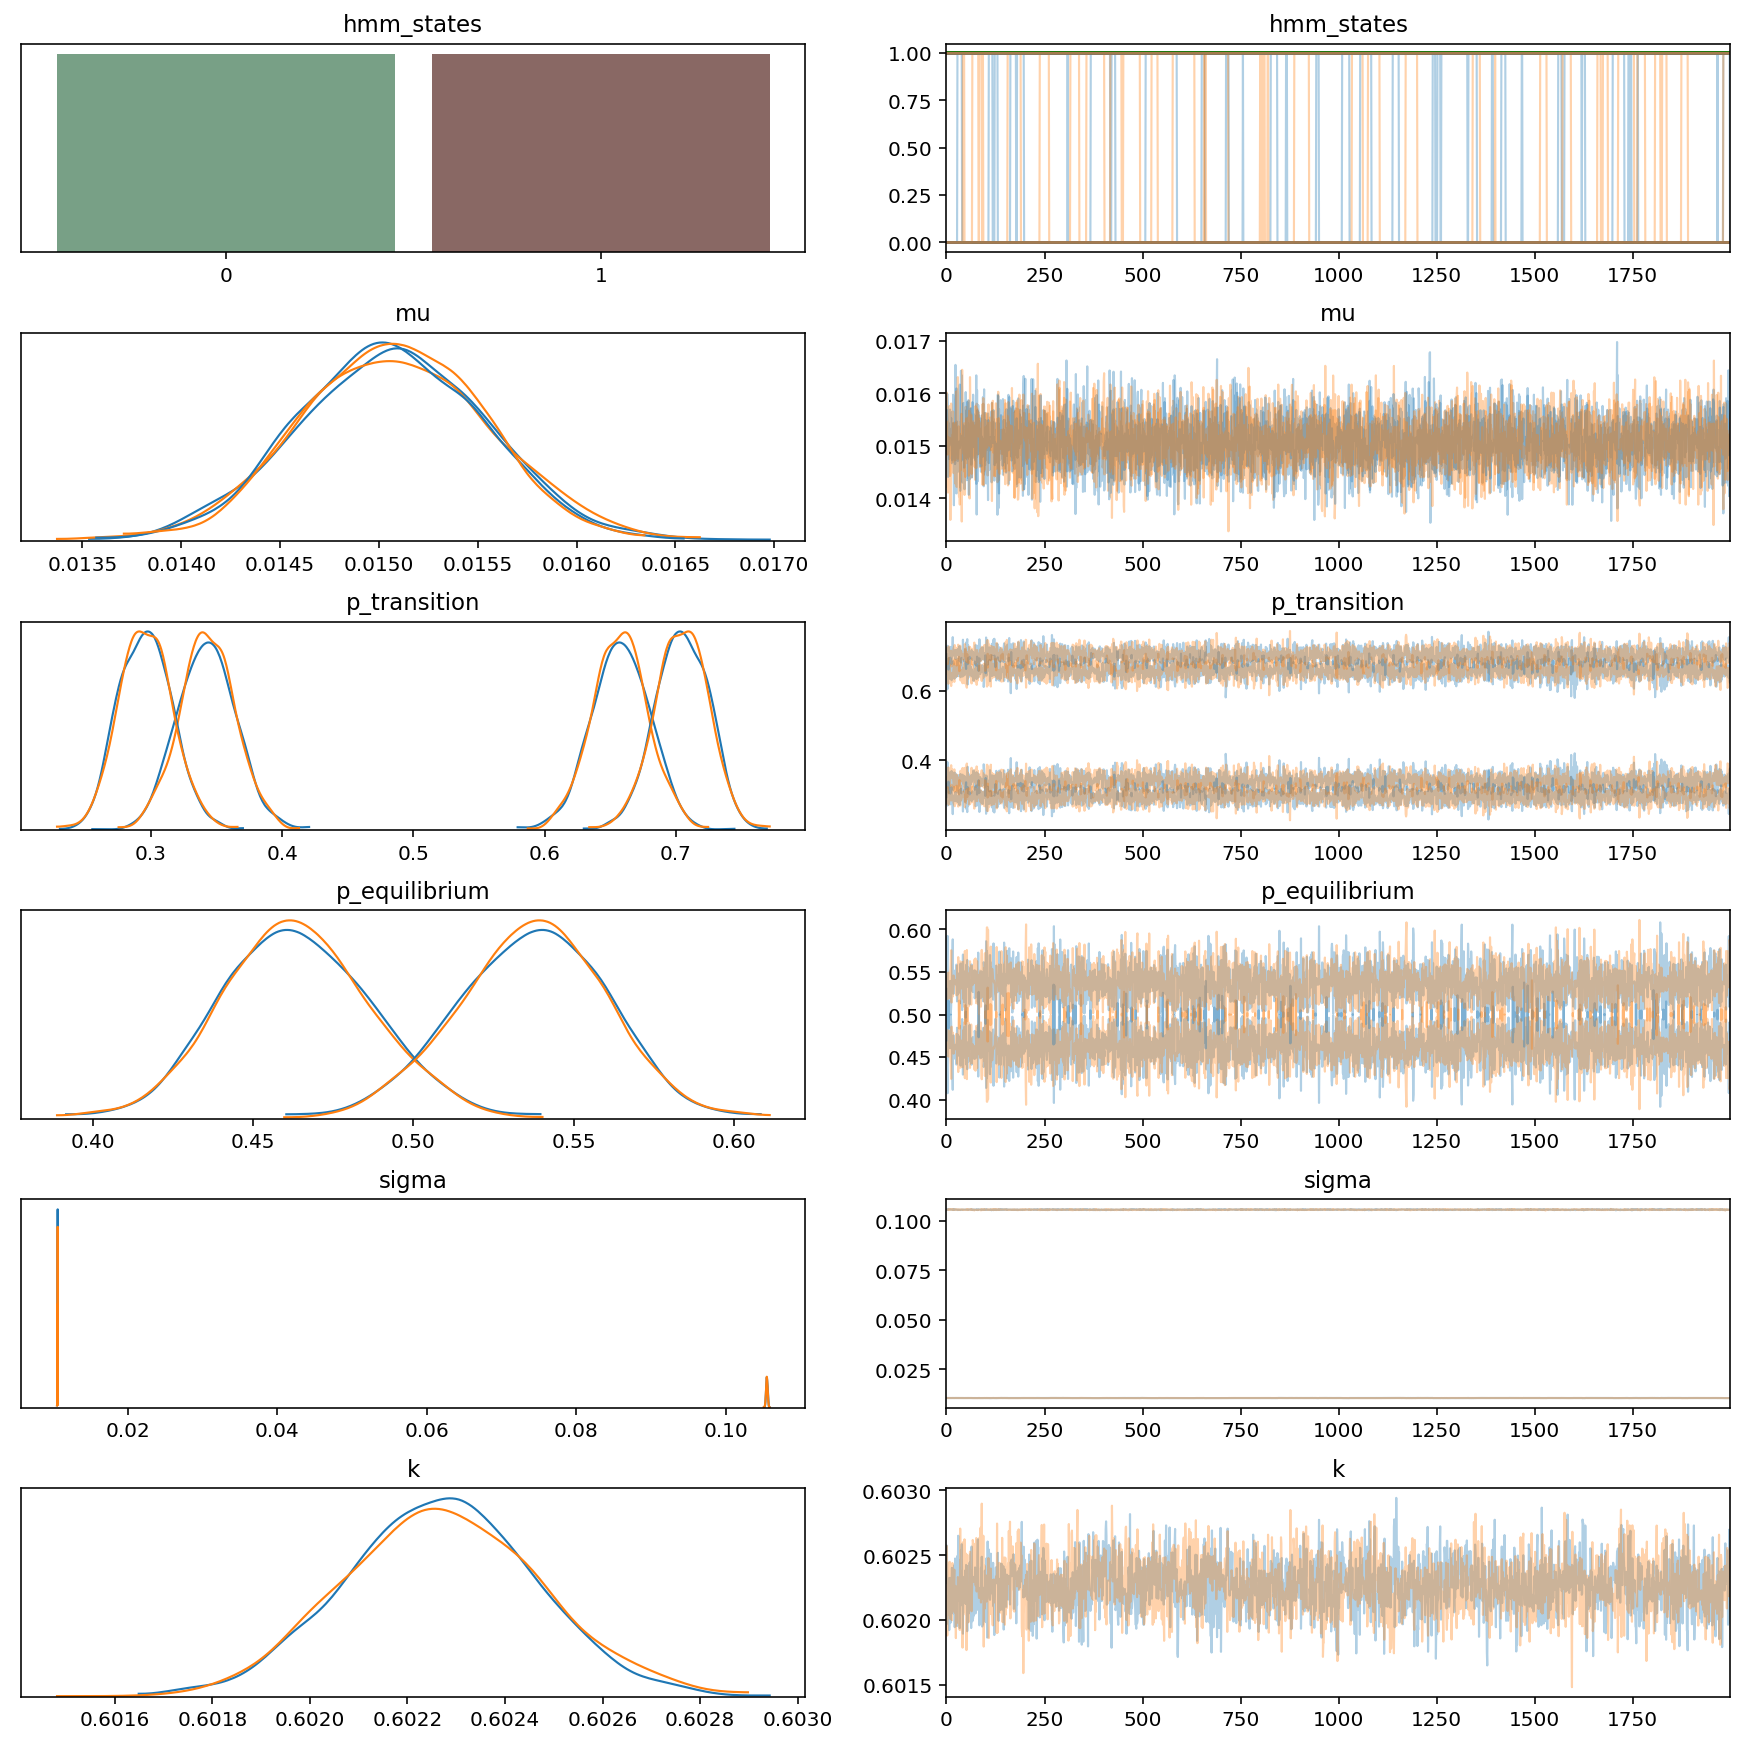

In [203]:
pm.traceplot(trace)
plt.show()

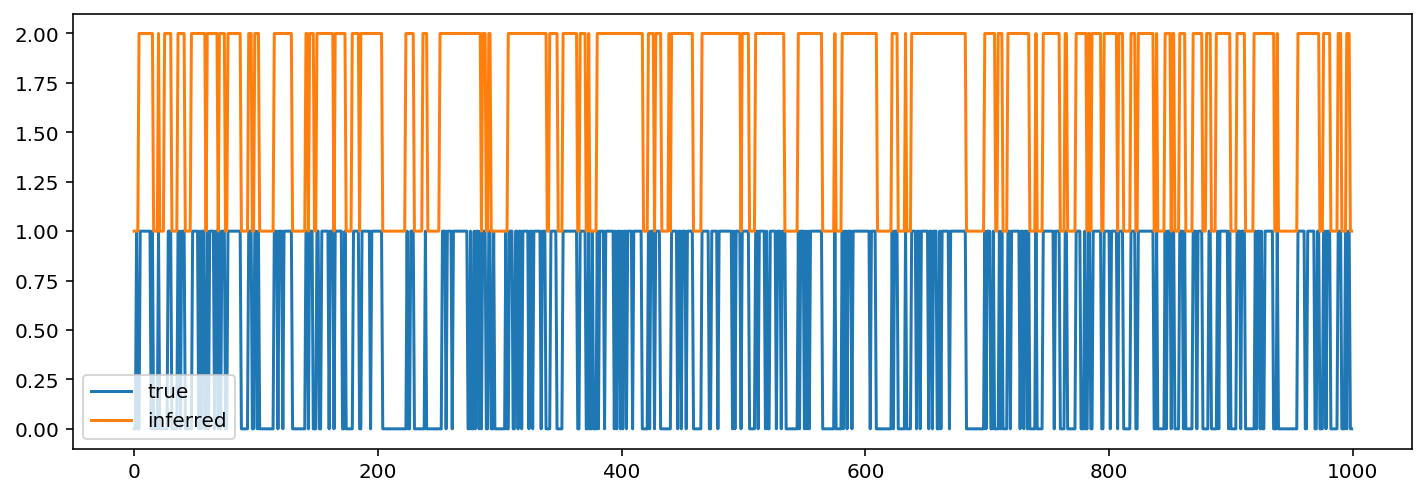

In [213]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(np.round(trace["hmm_states"].mean(axis=0)), label="true")
plt.plot(2 - np.array(states), label="inferred")
plt.legend();

In [214]:
p_transition_est=np.asarray(trace.get_values('p_transition', burn=0, combine=True))
p_transition_mean=np.mean(p_transition_est, axis=0)

In [215]:
p_transition_true, p_transition_mean

(array([[0.9, 0.1],
        [0.2, 0.8]]),
 array([[0.65749467, 0.34250533],
        [0.29563002, 0.70436998]]))

In [216]:
mu_est=np.asarray(trace.get_values('mu', burn=0, combine=True))
mu_mean=np.mean(mu_est, axis=0)

In [217]:
mu_mean

array([0.01506975, 0.01505369])